# Setup environment

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import copy
import pathlib

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

try:
    import lightgbm as lgb
except:
    print("lightgbm is not installed")

DATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station"
STATION_IDS = [211, 212, 213, 214, 215, 216]

BASE_FEATURE_COLS = [
    "NO2_quantrac",
    "PM25_quantrac",
    "O3_quantrac",
    "CO_quantrac",
    "Temperature_quantrac",
    "Humid_quantrac",
]

# Define lag and rolling windows for feature engineering
LAG_STEPS = [3, 6, 12, 24]
ROLL_WINDOWS = [3, 6, 12, 24]

# Define horizon (= n_past = n_future)
HORIZONS = [1, 24, 48, 72]

RANDOM_STATE = 42

# Directory to save the results and meta data
LIGHTGBM_DIR = f"/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/{datetime.now(timezone('Asia/Saigon')).strftime('%Y_%m_%d-%H_%M_%S')}"
pathlib.Path(LIGHTGBM_DIR).mkdir(parents=True, exist_ok=True)
print(LIGHTGBM_DIR)
with open(os.path.join(LIGHTGBM_DIR, "CONFIGURATIONS.txt"), "w") as f:
    f.write(f"BASE_FEATURE_COLS: {BASE_FEATURE_COLS}\n")
    f.write(f"LAG_STEPS: {LAG_STEPS}\n")
    f.write(f"ROLL_WINDOWS: {ROLL_WINDOWS}\n")
    f.write(f"HORIZONS: {HORIZONS}\n")
    f.write(f"RANDOM_STATE: {RANDOM_STATE}\n")

/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/2025_12_08-16_10_28


# Load dataset

In [2]:
def load_station_csv(station_id, data_dir=DATA_DIR):
    csv_path = os.path.join(data_dir, f"{station_id}.csv")
    df = pd.read_csv(csv_path)

    # Convert to datetime
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)

    # Remove unncessary column
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    # Add station_id column
    df["station_id"] = station_id
    return df

# Load dataset
dfs = []
for sid in STATION_IDS:
    df_sid = load_station_csv(sid, DATA_DIR)
    dfs.append(df_sid)
df_all = pd.concat(dfs, ignore_index=True)

# Sort data by station then date
df_all = df_all.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_all = df_all.loc[:, ["date"] + BASE_FEATURE_COLS + ["station_id"]]

print(df_all.shape)
print(df_all.columns)
df_all

(92966, 8)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'station_id'],
      dtype='object')


date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0     2021-02-23 21:00:00    112.740762      15.604762    55.431381   
1     2021-02-23 22:00:00    112.366471      14.594118    58.197176   
2     2021-02-23 23:00:00    112.700433      13.436667    55.029433   
3     2021-02-24 00:00:00    112.480867      12.365000    54.767700   
4     2021-02-24 01:00:00    114.331500      11.636667    53.786200   
...                   ...           ...            ...          ...   
92961 2022-12-31 19:00:00      0.088233      41.450000    75.916667   
92962 2022-12-31 20:00:00      0.083217      50.530000    66.116667   
92963 2022-12-31 21:00:00      0.084300      55.055000    55.133333   
92964 2022-12-31 22:00:00      0.066650      26.078333    46.750000   
92965 2022-12-31 23:00:00      0.067783      21.161667    50.016667   

       CO_quantrac  Temperature_quantrac  Humid_quantrac  station_id  
0        90.000000             28.361905       63.188095         211  
1      1200.603529             28.320588       63.773529         211  
2      1177.897000             28.336667       64.205000         211  
3        90.000000             28.305000       64.735000         211  
4        90.000000             28.300000       65.188333         211  
...            ...                   ...             ...         ...  
92961     2.087167             27.690000       67.290000         216  
92962     2.006500             27.401667       68.026667         216  
92963     2.418833             27.603333       66.965000         216  
92964     1.481500             27.036667       63.361667         216  
92965     1.301167             26.358333       63.343333         216  

[92966 rows x 8 columns]

In [3]:
df_all.isnull().sum()

date                        0
NO2_quantrac            43684
PM25_quantrac           43043
O3_quantrac             47797
CO_quantrac             43760
Temperature_quantrac    52890
Humid_quantrac          52890
station_id                  0
dtype: int64

# Data preparation

## Drop missing

Output: df_dropped

In [4]:
df_dropped = df_all.dropna().reset_index(drop=True)
df_dropped

date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0     2021-02-23 21:00:00    112.740762      15.604762    55.431381   
1     2021-02-23 22:00:00    112.366471      14.594118    58.197176   
2     2021-02-23 23:00:00    112.700433      13.436667    55.029433   
3     2021-02-24 00:00:00    112.480867      12.365000    54.767700   
4     2021-02-24 01:00:00    114.331500      11.636667    53.786200   
...                   ...           ...            ...          ...   
38704 2022-12-31 19:00:00      0.088233      41.450000    75.916667   
38705 2022-12-31 20:00:00      0.083217      50.530000    66.116667   
38706 2022-12-31 21:00:00      0.084300      55.055000    55.133333   
38707 2022-12-31 22:00:00      0.066650      26.078333    46.750000   
38708 2022-12-31 23:00:00      0.067783      21.161667    50.016667   

       CO_quantrac  Temperature_quantrac  Humid_quantrac  station_id  
0        90.000000             28.361905       63.188095         211  
1      1200.603529             28.320588       63.773529         211  
2      1177.897000             28.336667       64.205000         211  
3        90.000000             28.305000       64.735000         211  
4        90.000000             28.300000       65.188333         211  
...            ...                   ...             ...         ...  
38704     2.087167             27.690000       67.290000         216  
38705     2.006500             27.401667       68.026667         216  
38706     2.418833             27.603333       66.965000         216  
38707     1.481500             27.036667       63.361667         216  
38708     1.301167             26.358333       63.343333         216  

[38709 rows x 8 columns]

## Visualization (before converting)

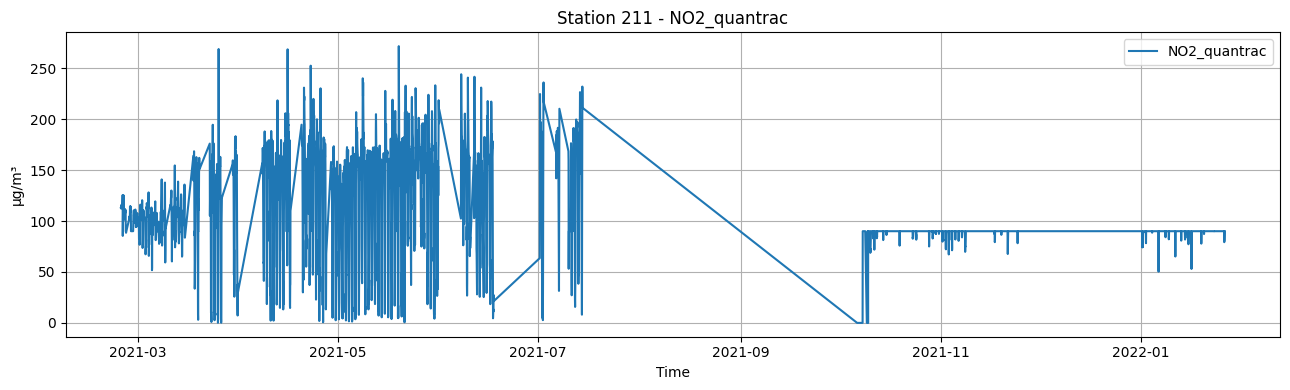

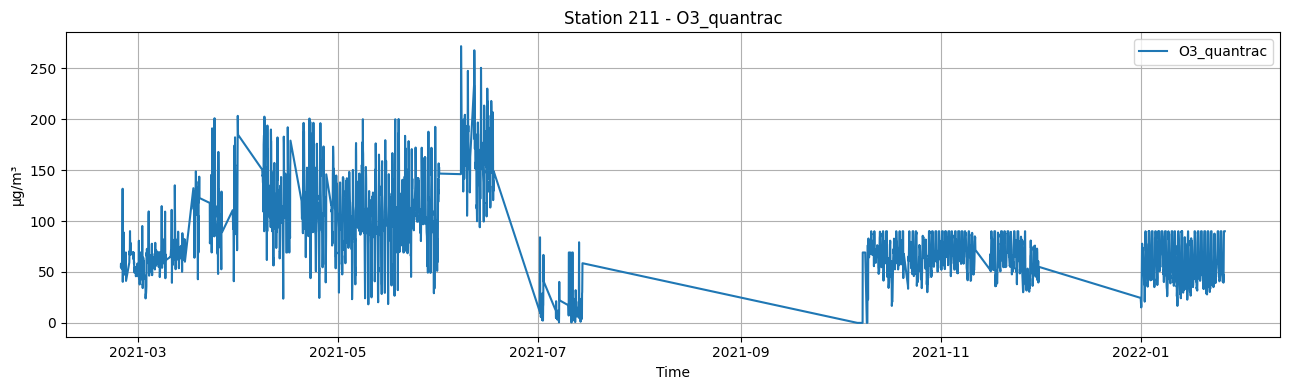

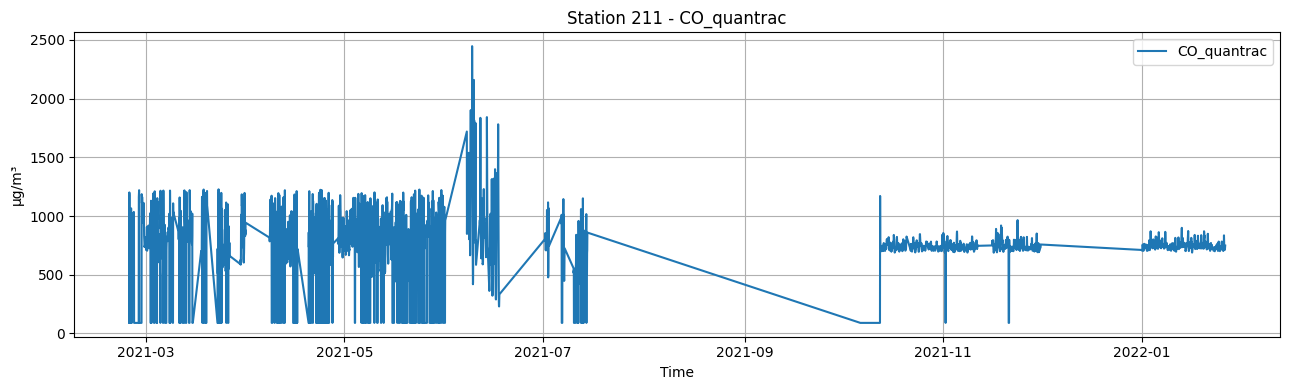

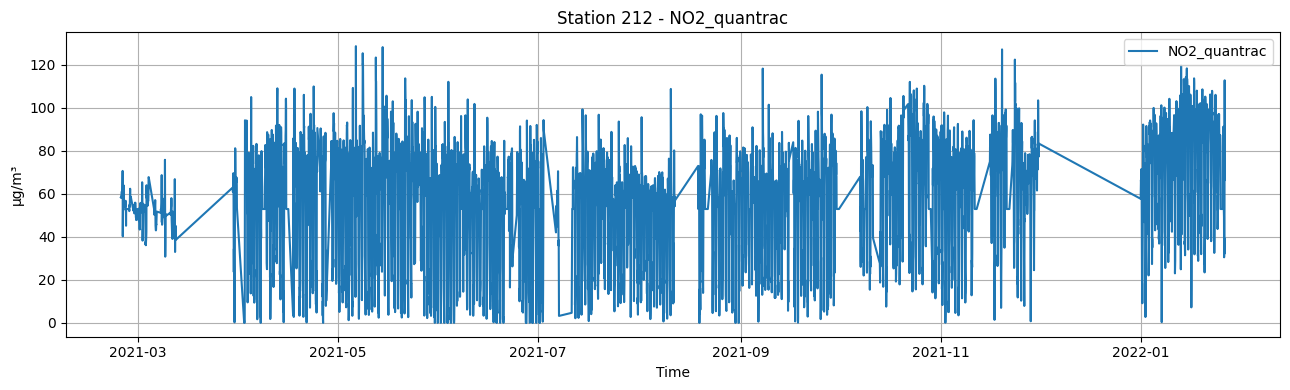

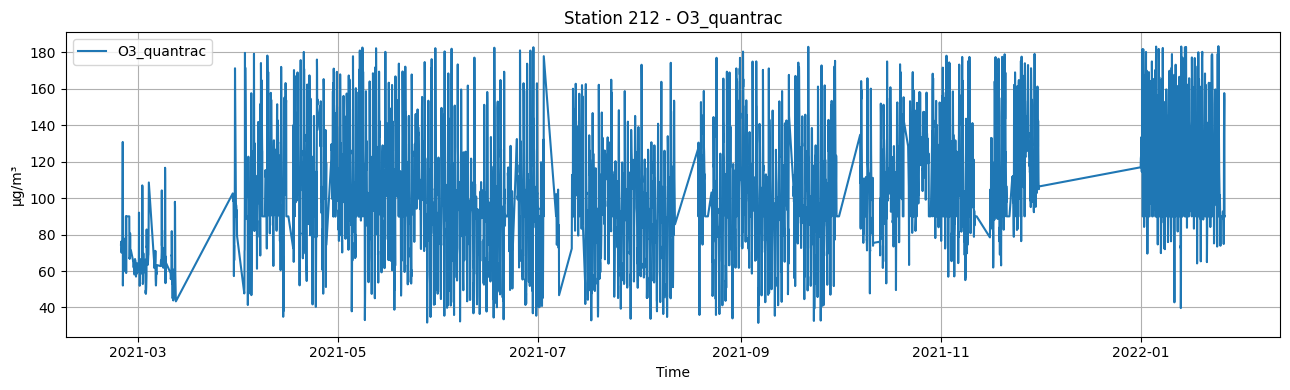

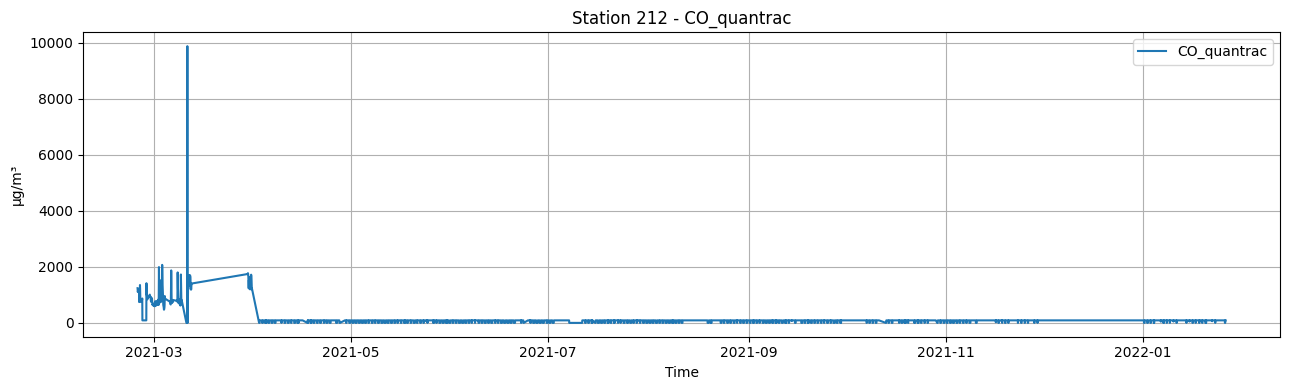

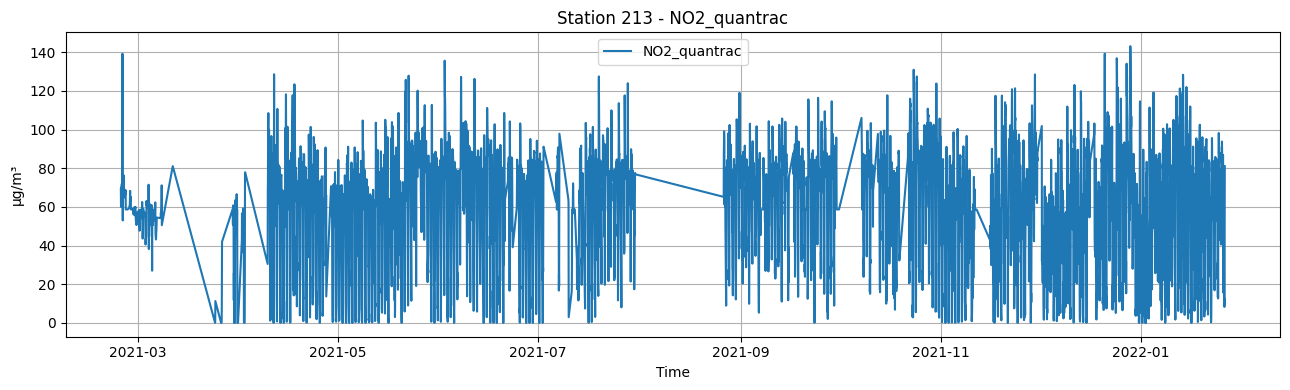

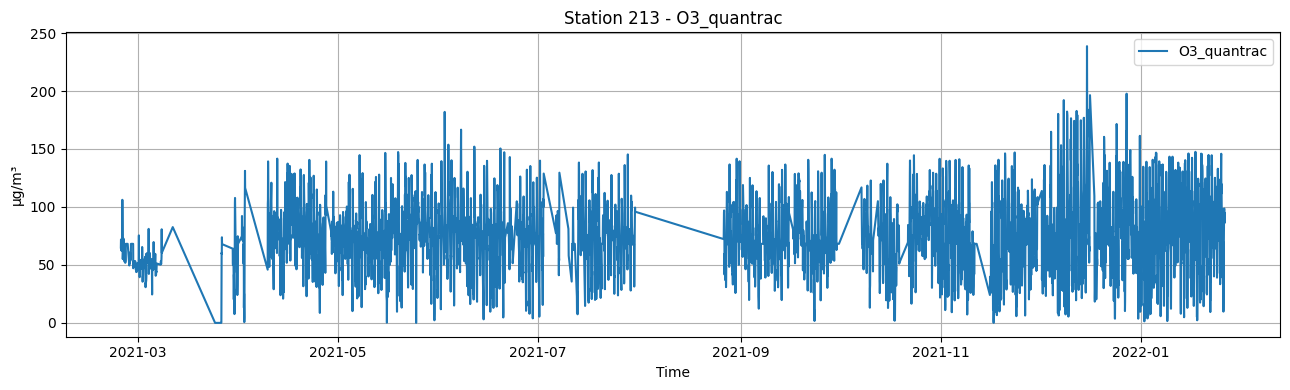

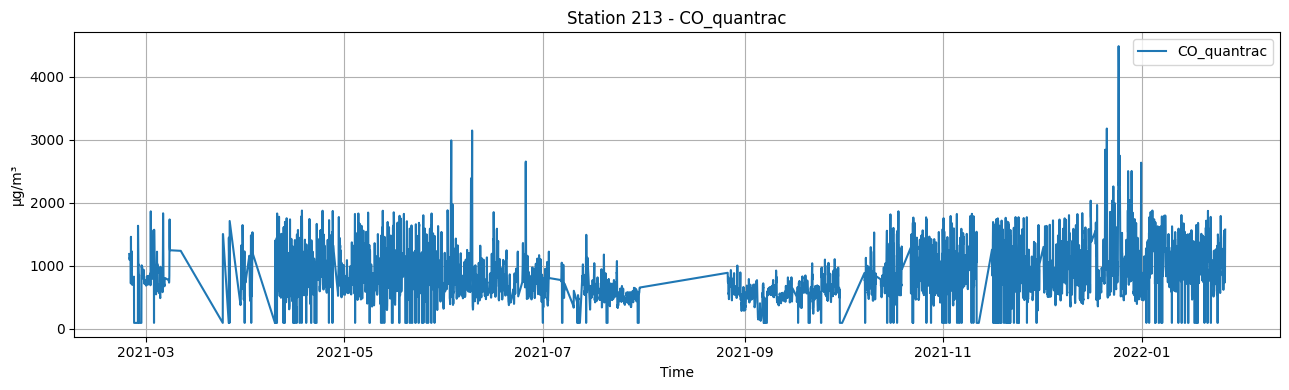

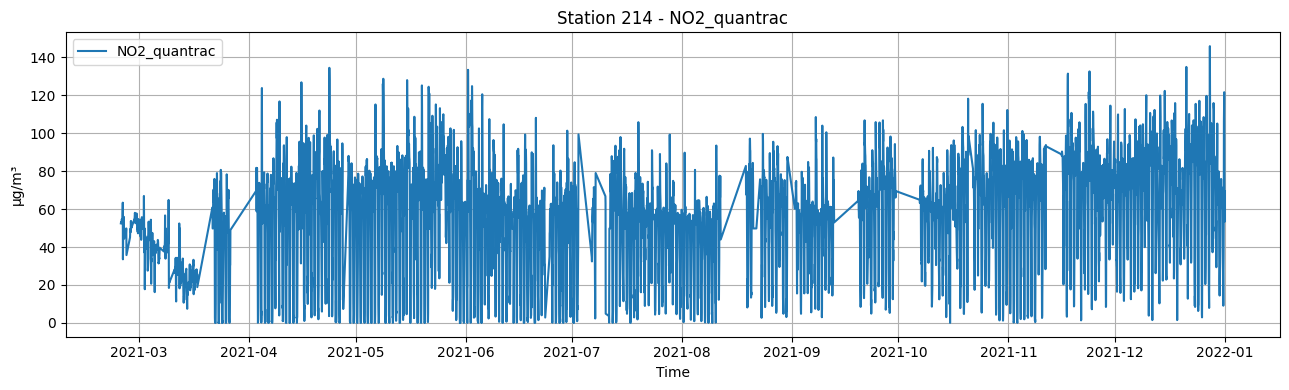

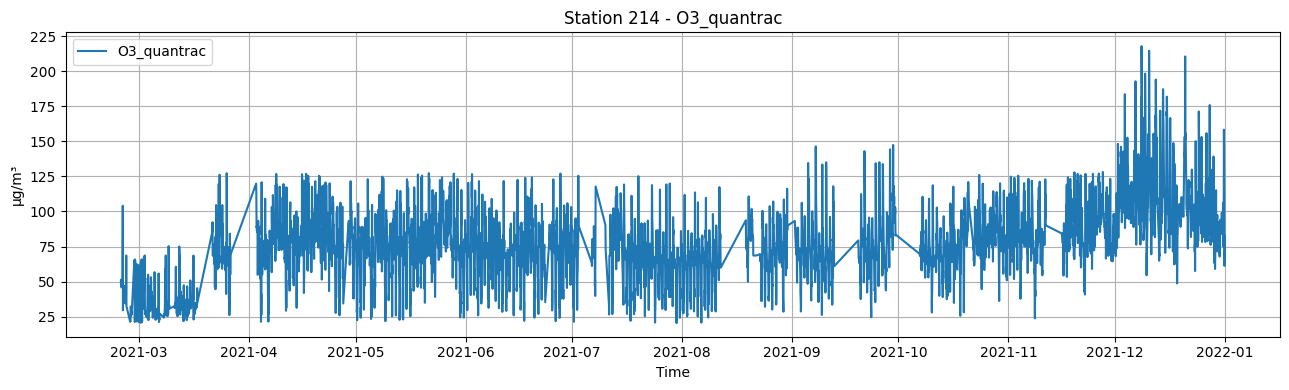

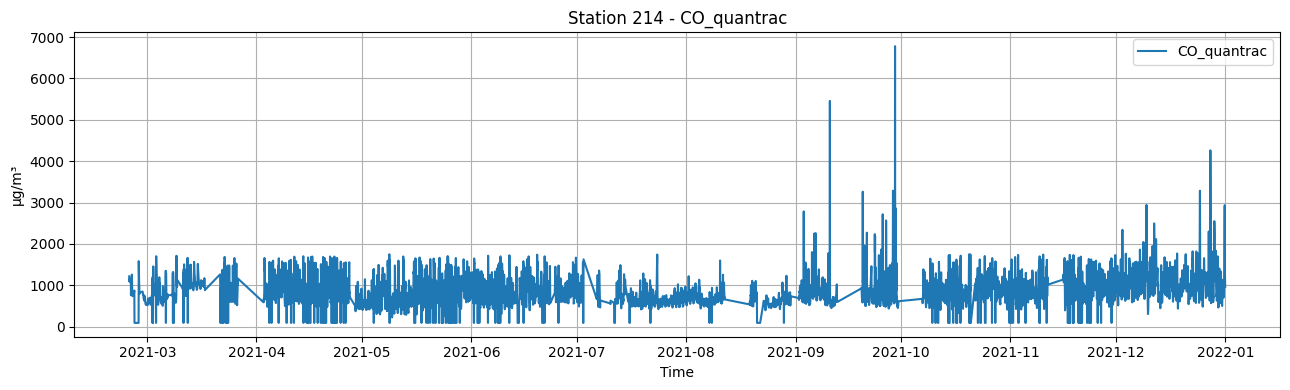

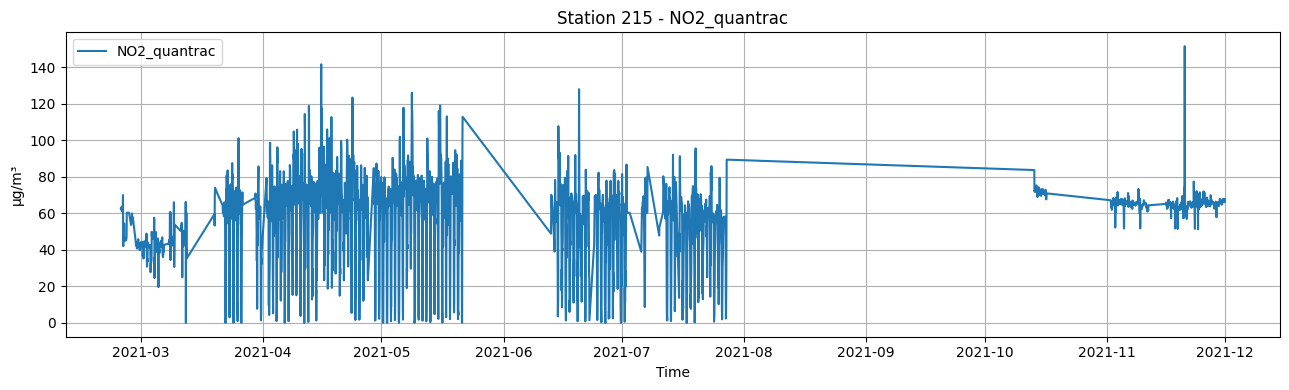

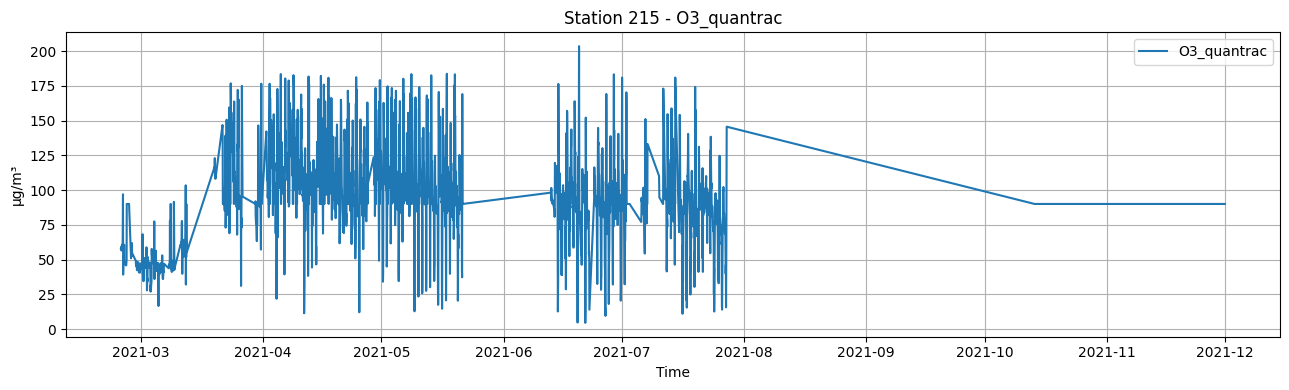

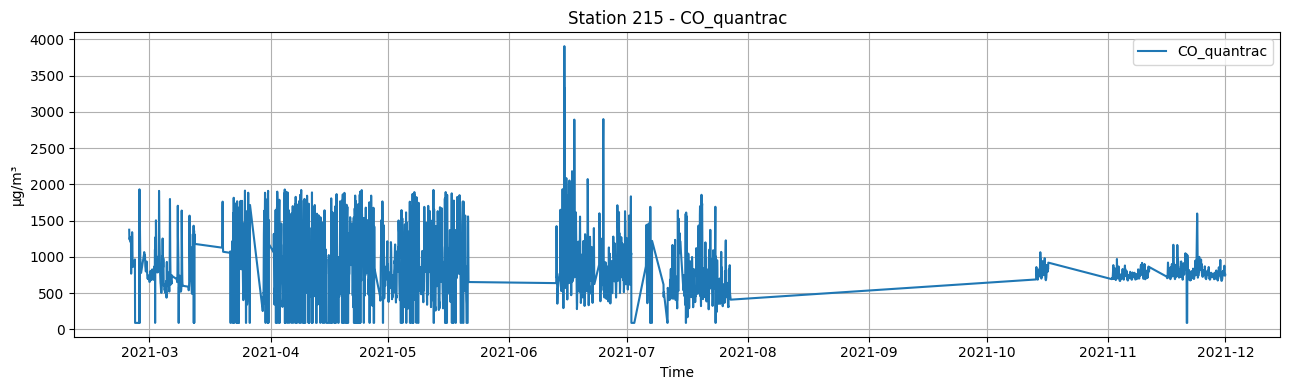

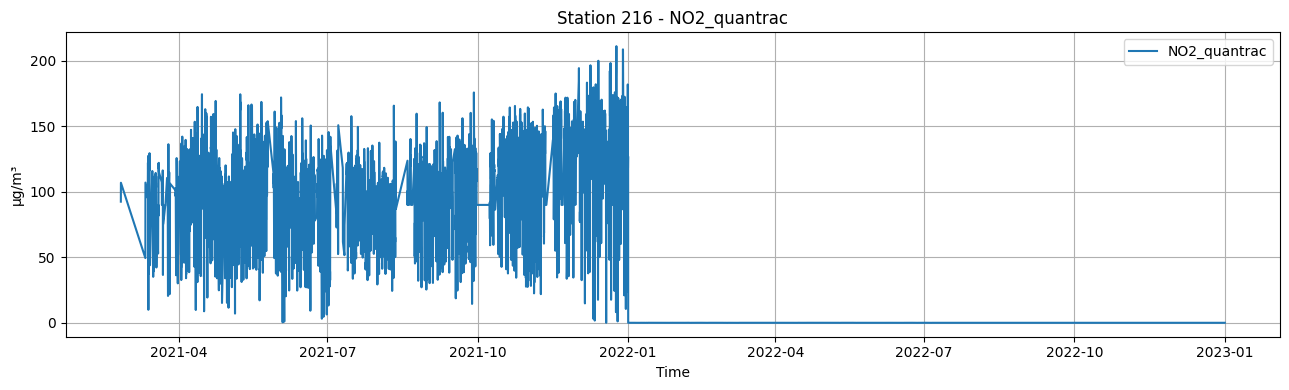

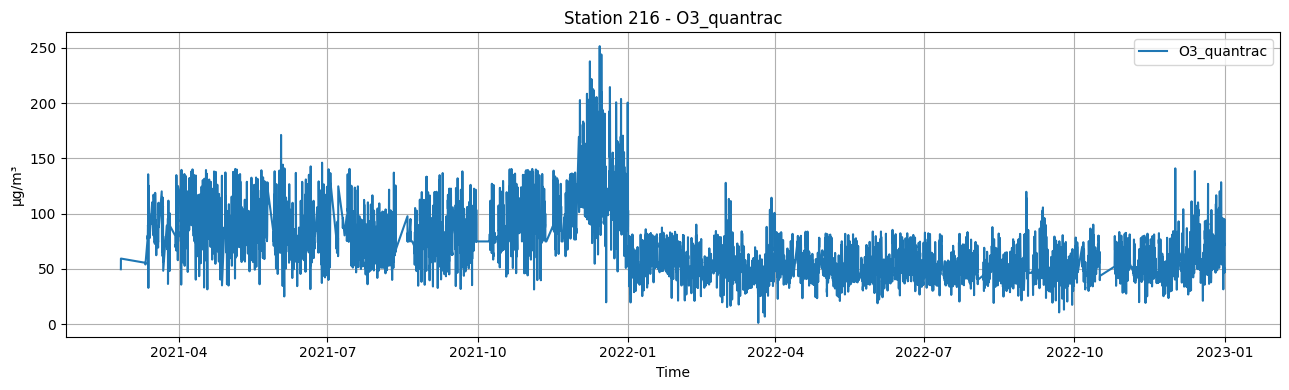

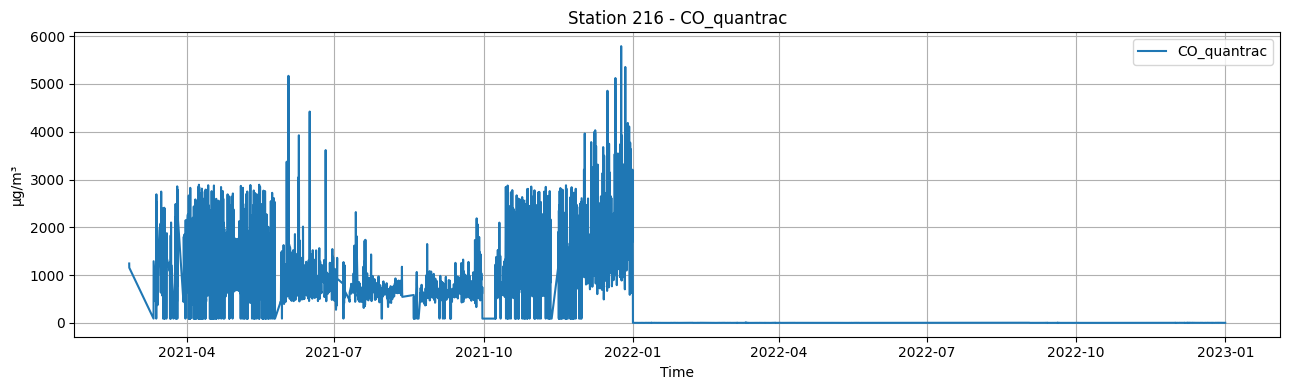

In [5]:
def plot_1_data(df, target_col, label, index, title, figsize=(13, 4)):
    plt.figure(figsize=figsize)
    plt.plot(index, df[target_col], label=label)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("µg/m³")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, target_col, df_station["date"], f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Convert ppm to ug/m3

Apply only to station 216, year 2022 on NO2, CO columns

Output: df_converted

In [6]:
df_converted = copy.deepcopy(df_dropped)
mask = (df_converted["station_id"] == 216) & (df_converted["date"] >= "2022-01-01")
df_converted.loc[mask, "NO2_quantrac"] = df_converted.loc[mask, "NO2_quantrac"].apply(lambda x: x * 1883.2)
df_converted.loc[mask, "CO_quantrac"] = df_converted.loc[mask, "CO_quantrac"].apply(lambda x: x * 1146.8)
df_converted

date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0     2021-02-23 21:00:00    112.740762      15.604762    55.431381   
1     2021-02-23 22:00:00    112.366471      14.594118    58.197176   
2     2021-02-23 23:00:00    112.700433      13.436667    55.029433   
3     2021-02-24 00:00:00    112.480867      12.365000    54.767700   
4     2021-02-24 01:00:00    114.331500      11.636667    53.786200   
...                   ...           ...            ...          ...   
38704 2022-12-31 19:00:00    166.161013      41.450000    75.916667   
38705 2022-12-31 20:00:00    156.713627      50.530000    66.116667   
38706 2022-12-31 21:00:00    158.753760      55.055000    55.133333   
38707 2022-12-31 22:00:00    125.515280      26.078333    46.750000   
38708 2022-12-31 23:00:00    127.649573      21.161667    50.016667   

       CO_quantrac  Temperature_quantrac  Humid_quantrac  station_id  
0        90.000000             28.361905       63.188095         211  
1      1200.603529             28.320588       63.773529         211  
2      1177.897000             28.336667       64.205000         211  
3        90.000000             28.305000       64.735000         211  
4        90.000000             28.300000       65.188333         211  
...            ...                   ...             ...         ...  
38704  2393.562733             27.690000       67.290000         216  
38705  2301.054200             27.401667       68.026667         216  
38706  2773.918067             27.603333       66.965000         216  
38707  1698.984200             27.036667       63.361667         216  
38708  1492.177933             26.358333       63.343333         216  

[38709 rows x 8 columns]

## Visualization (after converting)

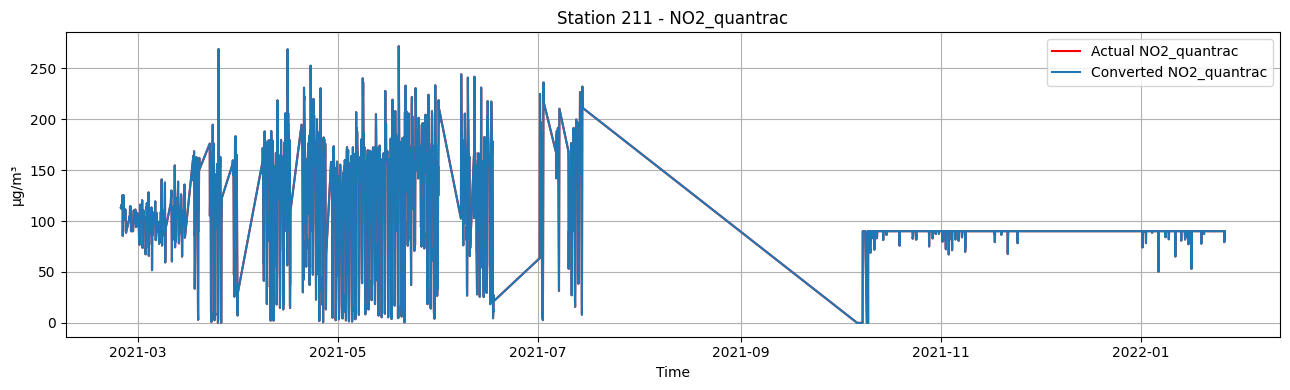

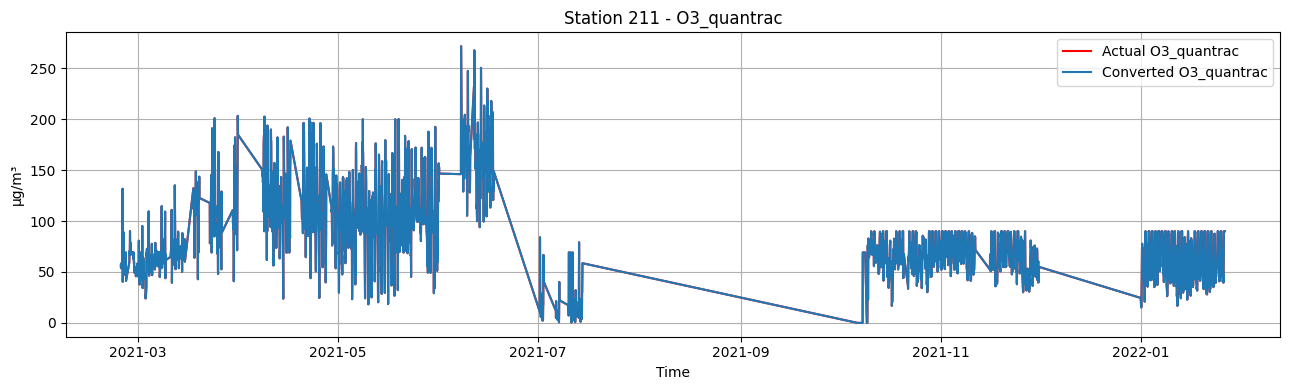

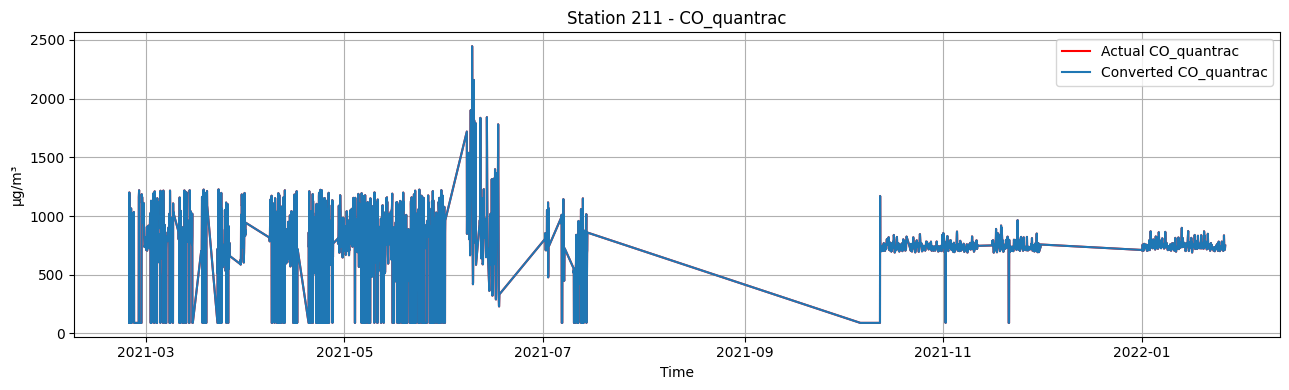

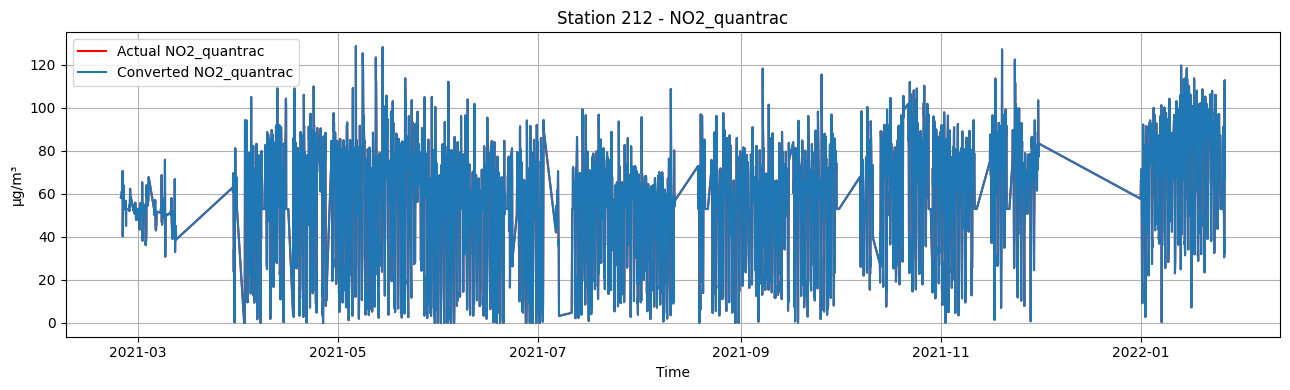

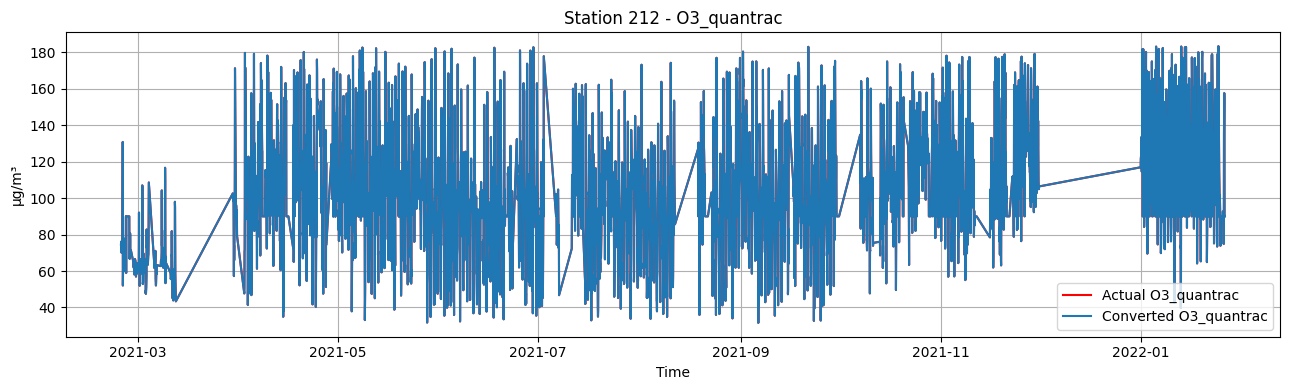

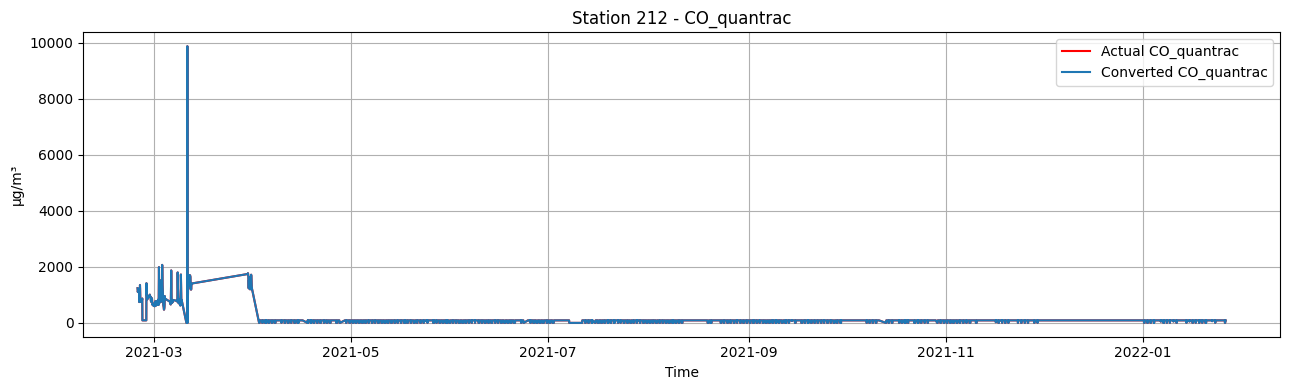

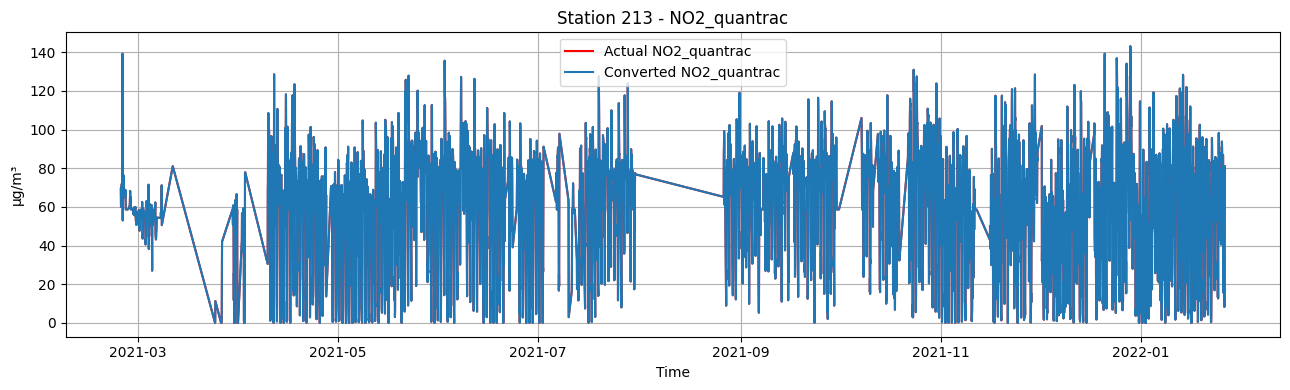

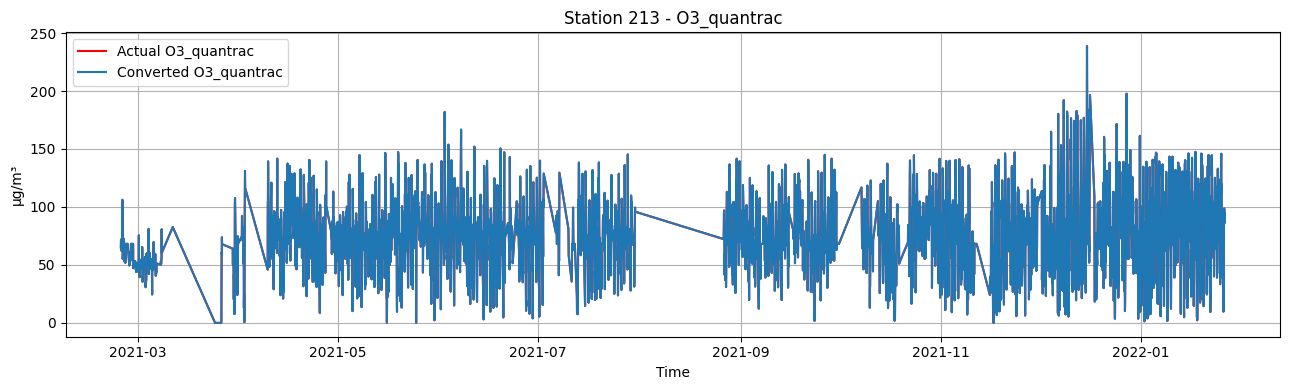

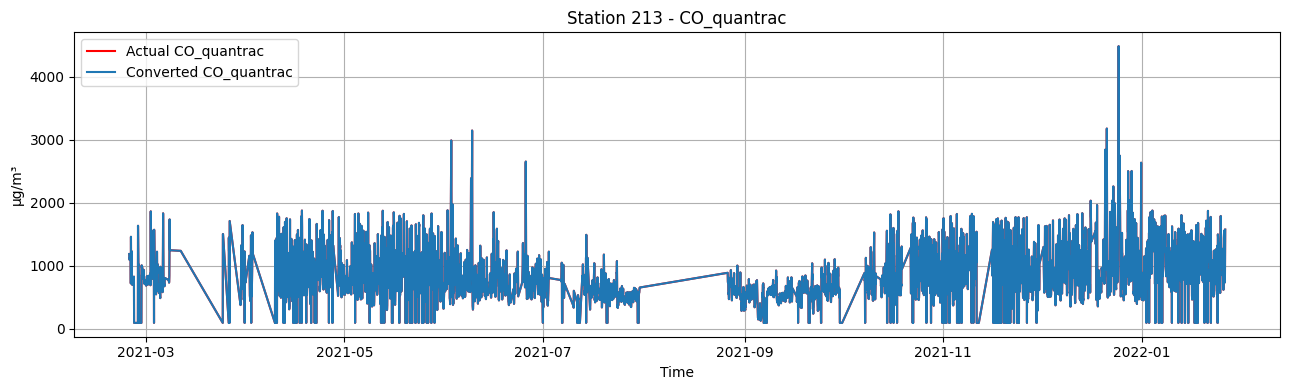

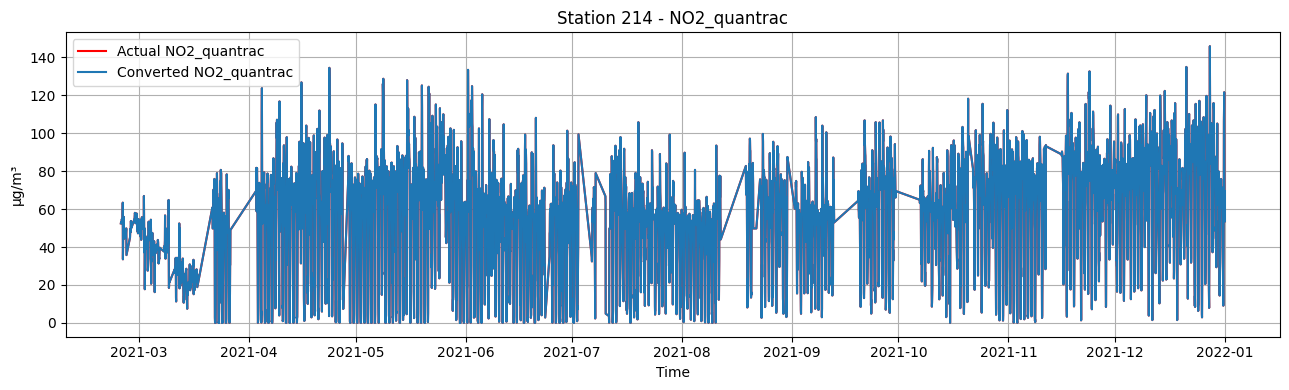

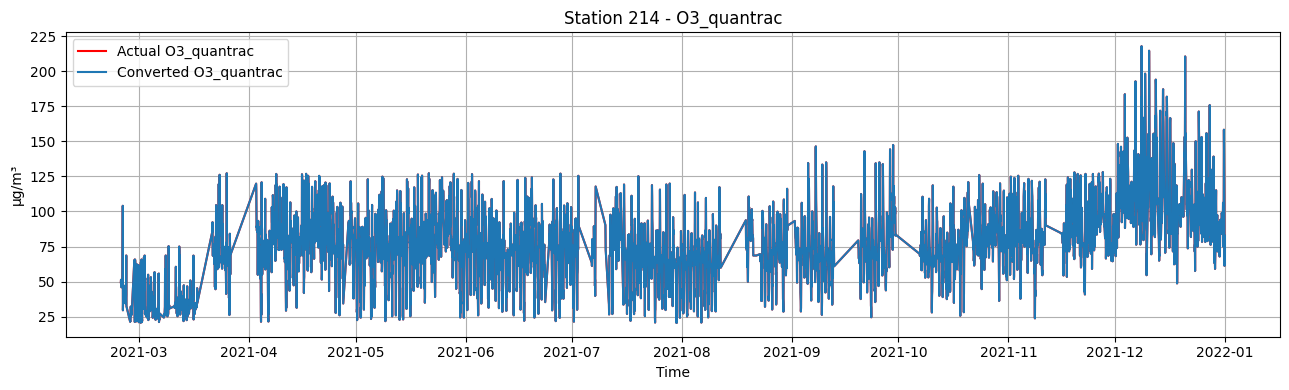

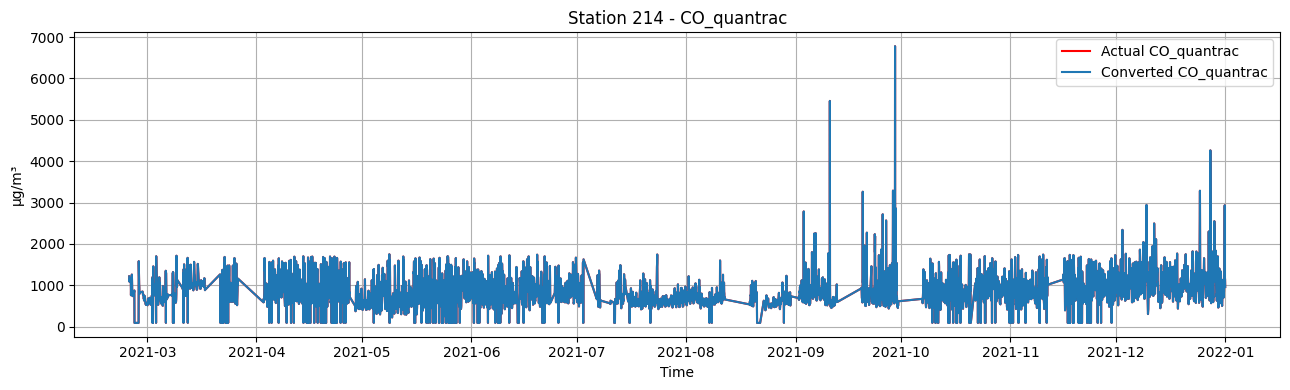

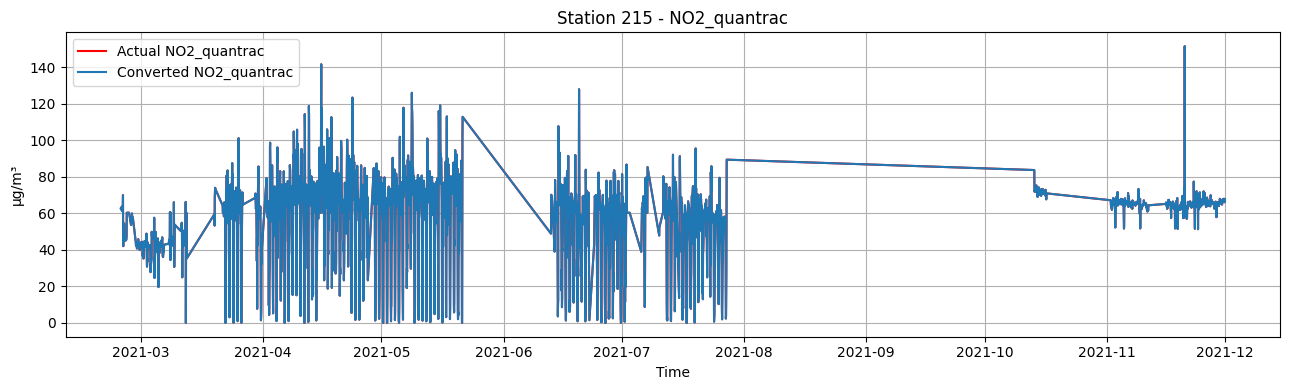

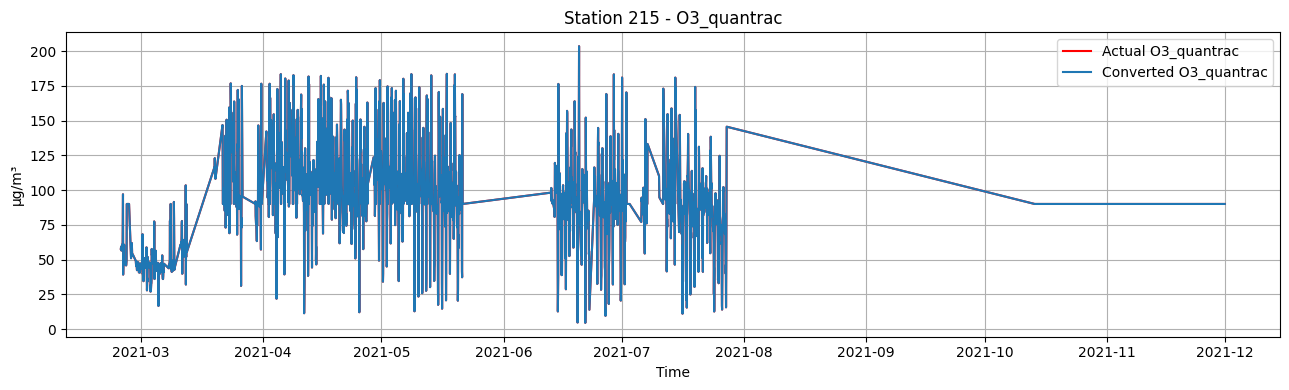

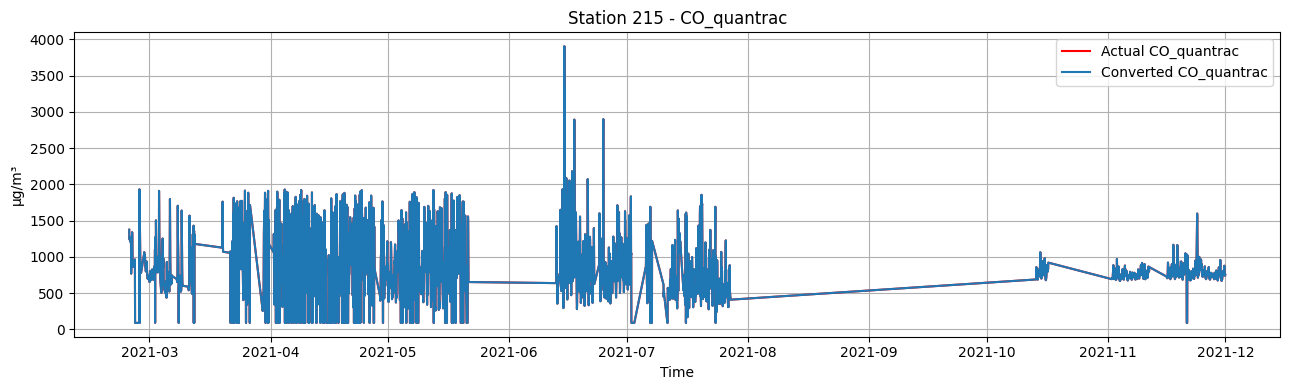

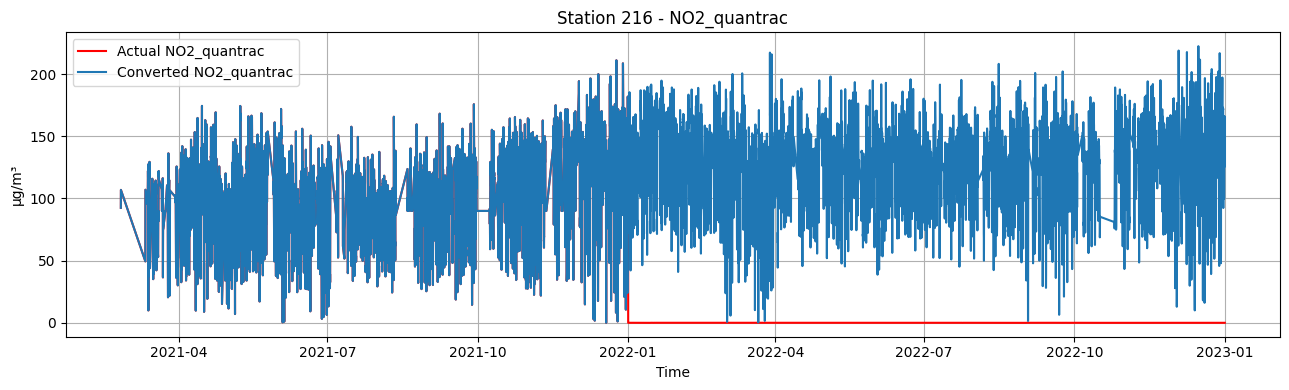

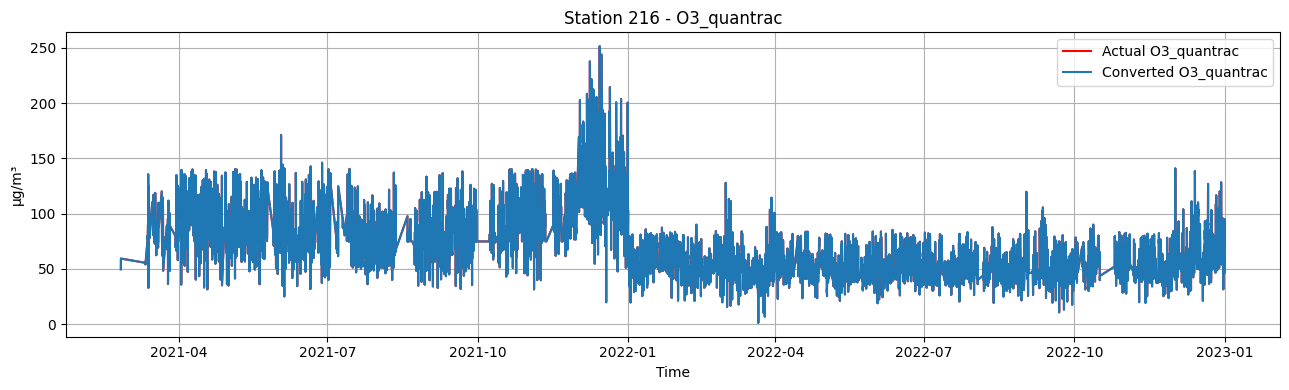

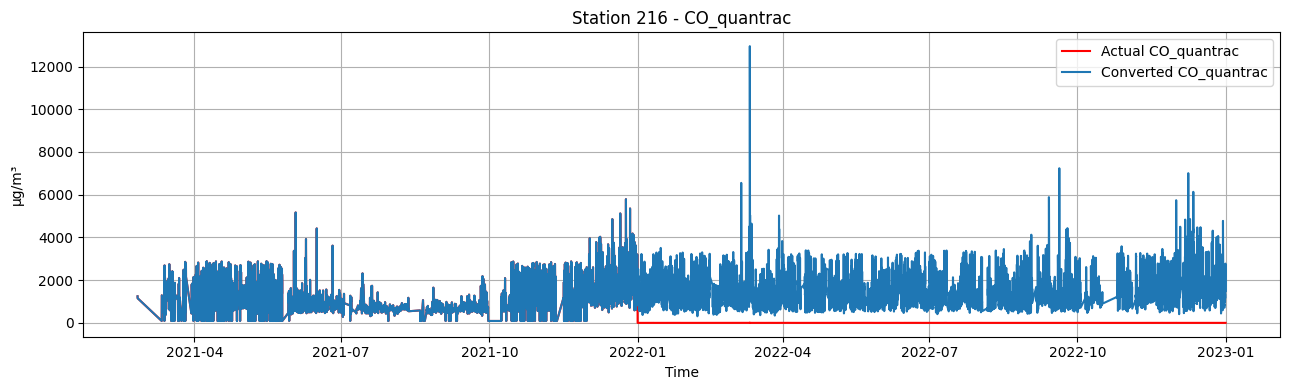

In [7]:
def plot_2_data(df1, target_col1, label1, df2, target_col2, label2, index, title, figsize=(13, 4)):
    plt.figure(figsize=figsize)
    plt.plot(index, df1[target_col1], label=label1, color="r")
    plt.plot(index, df2[target_col2], label=label2)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("µg/m³")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    df_station_converted = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_2_data(df_station, target_col, f"Actual {target_col}",
                        df_station_converted, target_col, f"Converted {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Feature engineering

In [8]:
def add_time_features(df, time_col="date"):
    df = df.copy()
    df["hour"] = df[time_col].dt.hour
    df["dayofweek"] = df[time_col].dt.dayofweek
    df["month"] = df[time_col].dt.month
    return df

# Add lag features for all FEATURES including LABEL
def add_lag_features(df, group_col, target_cols, lag_steps):
    df = df.copy()
    df = df.sort_values(["station_id", "date"])

    for col in target_cols:
        for lag in lag_steps:
            df[f"{col}_lag{lag}"] = df.groupby(group_col)[col].shift(lag)
    return df

# Just add the rolling features for LABEL
def add_rolling_features(df, group_col, target_cols, windows):
    assert isinstance(target_cols, list), "target_cols should be a list"

    df = df.copy()
    df = df.sort_values(["station_id", "date"])

    for col in target_cols:
        for w in windows:
            df[f"{col}_roll{w}_mean"] = (
                df.groupby(group_col)[col]
                  .shift(1) # use the past, avoid leaking
                  .rolling(window=w, min_periods=1)
                  .mean()
                  .reset_index(level=0, drop=True)
            )
            df[f"{col}_roll{w}_std"] = (
                df.groupby(group_col)[col]
                  .shift(1)
                  .rolling(window=w, min_periods=1)
                  .std()
                  .reset_index(level=0, drop=True)
            )
    return df

# Add time features and lag feature for all gases
dftestno2 = add_time_features(df_converted)
dftestno2 = add_lag_features(df_converted, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=[3, 6, 12, 24])
dftestno2 = add_rolling_features(df_converted, group_col="station_id", target_cols=["NO2_quantrac"], windows=[3, 6, 12, 24])
print(dftestno2.shape)
print(dftestno2.columns)
dftestno2

(38709, 16)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'station_id',
       'NO2_quantrac_roll3_mean', 'NO2_quantrac_roll3_std',
       'NO2_quantrac_roll6_mean', 'NO2_quantrac_roll6_std',
       'NO2_quantrac_roll12_mean', 'NO2_quantrac_roll12_std',
       'NO2_quantrac_roll24_mean', 'NO2_quantrac_roll24_std'],
      dtype='object')


date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0     2021-02-23 21:00:00    112.740762      15.604762    55.431381   
1     2021-02-23 22:00:00    112.366471      14.594118    58.197176   
2     2021-02-23 23:00:00    112.700433      13.436667    55.029433   
3     2021-02-24 00:00:00    112.480867      12.365000    54.767700   
4     2021-02-24 01:00:00    114.331500      11.636667    53.786200   
...                   ...           ...            ...          ...   
38704 2022-12-31 19:00:00    166.161013      41.450000    75.916667   
38705 2022-12-31 20:00:00    156.713627      50.530000    66.116667   
38706 2022-12-31 21:00:00    158.753760      55.055000    55.133333   
38707 2022-12-31 22:00:00    125.515280      26.078333    46.750000   
38708 2022-12-31 23:00:00    127.649573      21.161667    50.016667   

       CO_quantrac  Temperature_quantrac  Humid_quantrac  station_id  \
0        90.000000             28.361905       63.188095         211   
1      1200.603529             28.320588       63.773529         211   
2      1177.897000             28.336667       64.205000         211   
3        90.000000             28.305000       64.735000         211   
4        90.000000             28.300000       65.188333         211   
...            ...                   ...             ...         ...   
38704  2393.562733             27.690000       67.290000         216   
38705  2301.054200             27.401667       68.026667         216   
38706  2773.918067             27.603333       66.965000         216   
38707  1698.984200             27.036667       63.361667         216   
38708  1492.177933             26.358333       63.343333         216   

       NO2_quantrac_roll3_mean  NO2_quantrac_roll3_std  \
0                          NaN                     NaN   
1                   112.740762                     NaN   
2                   112.553616                0.264664   
3                   112.602555                0.205447   
4                   112.515924                0.169719   
...                        ...                     ...   
38704               147.203467               18.862212   
38705               160.574187                6.599564   
38706               161.714569                4.748040   
38707               160.542800                4.971295   
38708               146.994222               18.629258   

       NO2_quantrac_roll6_mean  NO2_quantrac_roll6_std  \
0                          NaN                     NaN   
1                   112.740762                     NaN   
2                   112.553616                0.264664   
3                   112.602555                0.205447   
4                   112.572133                0.178441   
...                        ...                     ...   
38704               127.011378               25.478626   
38705               138.106564               25.643475   
38706               146.183400               21.686363   
38707               153.873133               14.338064   
38708               153.784204               14.545310   

       NO2_quantrac_roll12_mean  NO2_quantrac_roll12_std  \
0                           NaN                      NaN   
1                    112.740762                      NaN   
2                    112.553616                 0.264664   
3                    112.602555                 0.205447   
4                    112.572133                 0.178441   
...                         ...                      ...   
38704                130.924249                19.684872   
38705                132.888531                21.995214   
38706                133.950447                22.869141   
38707                135.245147                23.859794   
38708                134.000142                23.952816   

       NO2_quantrac_roll24_mean  NO2_quantrac_roll24_std  
0                           NaN                      NaN  
1                    112.740762                      NaN  
2          

## Build supervised from time-series

In [9]:
# Reframe past future
def build_supervised_for_horizon(df, horizon_h, target_col):
    # Sort data by station_id then date
    df = df.copy()
    df = df.sort_values(["station_id", "date"])

    # Define target_name, which is the target_col plus horizon_h hour
    target_name = f"{target_col}_t_plus_{horizon_h}h"
    df[target_name] = df.groupby("station_id")[target_col].shift(-horizon_h)

    # Dropna after shifting
    df = df.dropna().reset_index(drop=True)

    # Define label, feature and meta columns
    label_cols = [target_name]
    meta_cols = ["date", "station_id"]
    feature_cols = [c for c in df.columns if c not in label_cols + meta_cols + [target_col]]

    # Get the X, y and meta data
    X = df[meta_cols + feature_cols]
    y = df[meta_cols + label_cols]

    return X, y

# Example
Xdummy, ydummy = build_supervised_for_horizon(dftestno2, horizon_h=72, target_col="NO2_quantrac")
print("Horizon 1h:", Xdummy.shape, ydummy.shape)
print(Xdummy.columns)
print(ydummy.columns)
display(Xdummy)
display(ydummy)

Horizon 1h: (38275, 15) (38275, 3)
Index(['date', 'station_id', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'NO2_quantrac_roll3_mean',
       'NO2_quantrac_roll3_std', 'NO2_quantrac_roll6_mean',
       'NO2_quantrac_roll6_std', 'NO2_quantrac_roll12_mean',
       'NO2_quantrac_roll12_std', 'NO2_quantrac_roll24_mean',
       'NO2_quantrac_roll24_std'],
      dtype='object')
Index(['date', 'station_id', 'NO2_quantrac_t_plus_72h'], dtype='object')


date  station_id  PM25_quantrac  O3_quantrac  \
0     2021-02-23 23:00:00         211      13.436667    55.029433   
1     2021-02-24 00:00:00         211      12.365000    54.767700   
2     2021-02-24 01:00:00         211      11.636667    53.786200   
3     2021-02-24 02:00:00         211      11.530000    55.814633   
4     2021-02-24 03:00:00         211      11.241667    54.800417   
...                   ...         ...            ...          ...   
38270 2022-12-28 19:00:00         216      32.163333    89.283333   
38271 2022-12-28 20:00:00         216      37.030000   116.950000   
38272 2022-12-28 21:00:00         216      40.385000   120.166667   
38273 2022-12-28 22:00:00         216      38.216667   105.000000   
38274 2022-12-28 23:00:00         216      26.083333    95.250000   

       CO_quantrac  Temperature_quantrac  Humid_quantrac  \
0      1177.897000             28.336667       64.205000   
1        90.000000             28.305000       64.735000   
2        90.000000             28.300000       65.188333   
3        90.000000             28.253333       65.561667   
4        90.000000             28.216667       65.925000   
...            ...                   ...             ...   
38270  2518.755067             29.625000       58.043333   
38271  2530.796467             28.140000       71.948333   
38272  1990.080267             27.395000       75.831667   
38273  1664.389067             26.738333       79.206667   
38274  1391.450667             26.205000       83.081667   

       NO2_quantrac_roll3_mean  NO2_quantrac_roll3_std  \
0                   112.553616                0.264664   
1                   112.602555                0.205447   
2                   112.515924                0.169719   
3                   113.170933                1.011058   
4                   114.268767                1.757373   
...                        ...                     ...   
38270               159.214098               20.857906   
38271               173.348560                6.878694   
38272               190.454293               22.857511   
38273               202.496311               21.040829   
38274               208.428391               10.880102   

       NO2_quantrac_roll6_mean  NO2_quantrac_roll6_std  \
0                   112.553616                0.264664   
1                   112.602555                0.205447   
2                   112.572133                0.178441   
3                   112.924006                0.801845   
4                   113.435661                1.443990   
...                        ...                     ...   
38270               114.184693               53.684851   
38271               136.280907               46.722462   
38272               156.169591               52.005798   
38273               180.855204               30.217751   
38274               190.888476               20.867573   

       NO2_quantrac_roll12_mean  NO2_quantrac_roll12_std  \
0                    112.553616                 0.264664   
1                    112.602555                 0.205447   
2                    112.572133                 0.178441   
3                    112.924006                 0.801845   
4                    113.435661                 1.443990   
...                         ...                      ...   
38270                127.581569                55.785534   
38271                128.130836                56.290097   
38272                130.066347                59.075982   
38273                132.569433                62.051474   
38274                135.041133                64.082309   

       NO2_quantrac_roll24_mean  NO2_quantrac_roll24_std  
0                    112.553616                 0.264664  
1                    112.602555                 0.205447  
2                    112.572133                 0.178441  
3                    112.924006                 0.801845  
4                    113.435661                 1.443990  
..

date  station_id  NO2_quantrac_t_plus_72h
0     2021-02-23 23:00:00         211               105.341135
1     2021-02-24 00:00:00         211                98.306824
2     2021-02-24 01:00:00         211               100.530167
3     2021-02-24 02:00:00         211               101.188867
4     2021-02-24 03:00:00         211               102.945400
...                   ...         ...                      ...
38270 2022-12-28 19:00:00         216               166.161013
38271 2022-12-28 20:00:00         216               156.713627
38272 2022-12-28 21:00:00         216               158.753760
38273 2022-12-28 22:00:00         216               125.515280
38274 2022-12-28 23:00:00         216               127.649573

[38275 rows x 3 columns]

## Split train/validation/test for each station

In [10]:
def train_test_validation_split(X, y, train_ratio=0.7, val_ratio=0.15):
    assert (X["date"].equals(y["date"]) and X["station_id"].equals(y["station_id"])), "X and y should have the same metadata values"

    X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []
    meta_train, meta_val, meta_test = [], [], []

    meta_cols = ["date", "station_id"]
    
    for station in list(sorted(X["station_id"].unique())):
        X_station = X[X["station_id"] == station]
        y_station = y[y["station_id"] == station]
        meta = X_station[meta_cols]

        X_station = X_station.drop(columns=meta_cols)
        y_station = y_station.drop(columns=meta_cols)
    
        n = len(X_station)
        train_end = int(n * train_ratio)
        val_end = int(n * (train_ratio + val_ratio))
    
        X_train.append(X_station.iloc[:train_end])
        y_train.append(y_station.iloc[:train_end])
        meta_train.append(meta.iloc[:train_end])
    
        X_val.append(X_station.iloc[train_end:val_end])
        y_val.append(y_station.iloc[train_end:val_end])
        meta_val.append(meta.iloc[train_end:val_end])
    
        X_test.append(X_station.iloc[val_end:])
        y_test.append(y_station.iloc[val_end:])
        meta_test.append(meta.iloc[val_end:])

    X_train = pd.concat(X_train, axis=0)
    X_val = pd.concat(X_val, axis=0)
    X_test = pd.concat(X_test, axis=0)
    
    y_train = pd.concat(y_train, axis=0)
    y_val = pd.concat(y_val, axis=0)
    y_test = pd.concat(y_test, axis=0)
    
    meta_train = pd.concat(meta_train, axis=0)
    meta_val = pd.concat(meta_val, axis=0)
    meta_test = pd.concat(meta_test, axis=0)

    return (X_train, y_train, meta_train, X_val, y_val, meta_val, X_test, y_test, meta_test)

# Example
(X_train_dummy, y_train_dummy, meta_train_dummy,
 X_val_dummy, y_val_dummy, meta_val_dummy,
 X_test_dummy, y_test_dummy, meta_test_dummy) = train_test_validation_split(Xdummy, ydummy)
display(X_test_dummy)

PM25_quantrac  O3_quantrac  CO_quantrac  Temperature_quantrac  \
3287       13.133333    75.250430   702.803600             30.283333   
3288       13.983333    67.026909   707.368500             29.095000   
3289       18.483333    62.043188   722.935000             27.650000   
3290       22.583333    67.859831   742.837200             27.825000   
3291       24.950000    70.576204   768.985100             27.863333   
...              ...          ...          ...                   ...   
38270      32.163333    89.283333  2518.755067             29.625000   
38271      37.030000   116.950000  2530.796467             28.140000   
38272      40.385000   120.166667  1990.080267             27.395000   
38273      38.216667   105.000000  1664.389067             26.738333   
38274      26.083333    95.250000  1391.450667             26.205000   

       Humid_quantrac  NO2_quantrac_roll3_mean  NO2_quantrac_roll3_std  \
3287        70.961667                90.000000                0.000000   
3288        75.575000                90.000000                0.000000   
3289        85.500000                90.000000                0.000000   
3290        86.958333                90.000000                0.000000   
3291        86.801667                90.000000                0.000000   
...               ...                      ...                     ...   
38270       58.043333               159.214098               20.857906   
38271       71.948333               173.348560                6.878694   
38272       75.831667               190.454293               22.857511   
38273       79.206667               202.496311               21.040829   
38274       83.081667               208.428391               10.880102   

       NO2_quantrac_roll6_mean  NO2_quantrac_roll6_std  \
3287                 90.000000                0.000000   
3288                 90.000000                0.000000   
3289                 90.000000                0.000000   
3290                 90.000000                0.000000   
3291                 90.000000                0.000000   
...                        ...                     ...   
38270               114.184693               53.684851   
38271               136.280907               46.722462   
38272               156.169591               52.005798   
38273               180.855204               30.217751   
38274               190.888476               20.867573   

       NO2_quantrac_roll12_mean  NO2_quantrac_roll12_std  \
3287                  90.000000                 0.000000   
3288                  90.000000                 0.000000   
3289                  90.000000                 0.000000   
3290                  90.000000                 0.000000   
3291                  90.000000                 0.000000   
...                         ...                      ...   
38270                127.581569                55.785534   
38271                128.130836                56.290097   
38272                130.066347                59.075982   
38273                132.569433                62.051474   
38274                135.041133                64.082309   

       NO2_quantrac_roll24_mean  NO2_quantrac_roll24_std  
3287                  90.000000                 0.000000  
3288                  90.000000                 0.000000  
3289                  90.000000                 0.000000  
3290                  90.000000                 0.000000  
3291                  90.000000                 0.000000  
...                         ...                      ...  
38270                151.632738                46.865551  
38271                152.433098                47.162243  
38272                154.560852                48.908902  
38273                155.969329                50.101296  
38274                156.608832                50.527986  

[5744 rows x 13 columns]

## Apply IQR on test set only

In [11]:
# Return the index of outliers, using IQR
def get_outliers_indices(df, target_col):
    df = copy.deepcopy(df)

    Q3 = np.quantile(df[target_col], 0.75)
    Q1 = np.quantile(df[target_col], 0.25)
    IQR = Q3 - Q1
    print(f"IQR value for column {target_col} is: {IQR}")

    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    print(f"lower_range = {lower_range}, upper_range = {upper_range}")

    display(df)

    invalid_records = df[(df[target_col] < lower_range) | (df[target_col] > upper_range)]

    return list(invalid_records.index)

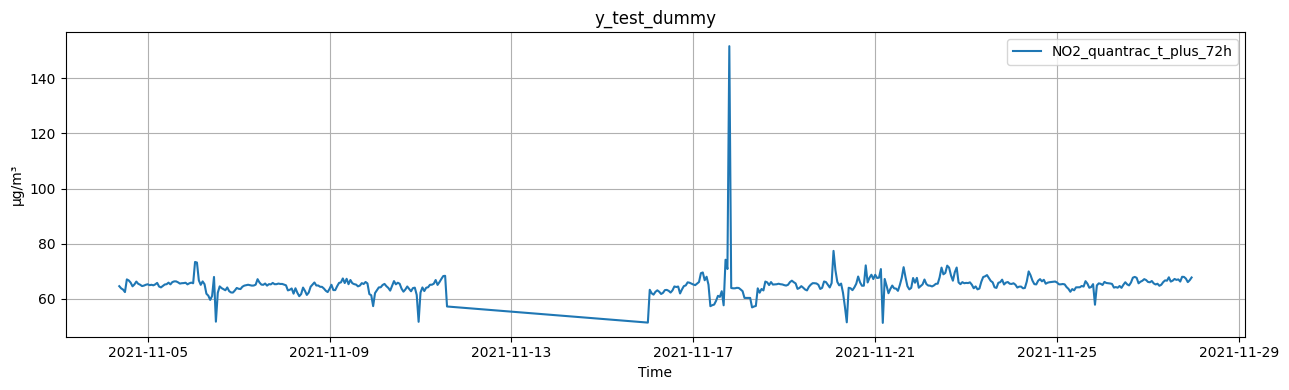

IQR value for column NO2_quantrac_t_plus_72h is: 2.1086958536600946
lower_range = 60.78396270602208, upper_range = 69.21874612066246


NO2_quantrac_t_plus_72h
24172                64.629902
24173                63.832055
24174                63.402800
24175                62.488546
24176                67.086371
...                        ...
24629                67.982983
24630                67.366411
24631                66.097731
24632                66.795768
24633                67.780424

[462 rows x 1 columns]

removed_indices = [24212, 24213, 24220, 24223, 24306, 24330, 24345, 24346, 24374, 24375, 24379, 24380, 24381, 24382, 24384, 24386, 24387, 24388, 24389, 24397, 24398, 24399, 24400, 24401, 24402, 24403, 24444, 24445, 24450, 24451, 24461, 24469, 24470, 24481, 24501, 24503, 24504, 24505, 24508, 24509, 24547, 24582]
Removed data: 


NO2_quantrac_t_plus_72h
24212                73.413354
24213                73.196216
24220                59.658703
24223                51.763739
24306                57.398350
24330                51.714388
24345                57.267949
24346                51.430331
24374                69.333330
24375                69.608871
24379                57.381449
24380                57.739798
24381                57.962792
24382                59.321771
24384                60.731424
24386                57.699731
24387                74.213533
24388                70.857300
24389               151.626467
24397                60.376704
24398                60.376704
24399                60.376704
24400                60.376704
24401                56.933349
24402                57.255783
24403                57.463187
24444                77.426924
24445                70.429768
24450                57.220742
24451                51.529467
24461                72.168932
24469                70.830377
24470                51.324771
24481                71.525537
24501                71.357116
24503                69.434725
24504                72.074295
24505                71.353265
24508                69.658041
24509                71.390542
24547                69.974138
24582                57.906552

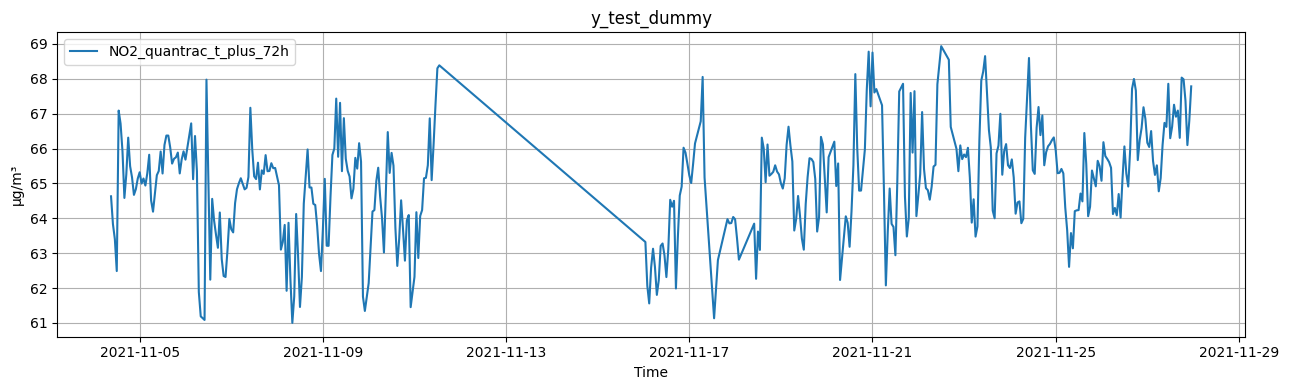

In [12]:
meta215 = meta_test_dummy[meta_test_dummy["station_id"] == 215]
test215 = y_test_dummy.loc[meta215.index]
plot_1_data(test215, "NO2_quantrac_t_plus_72h", "NO2_quantrac_t_plus_72h", meta215["date"], "y_test_dummy")

removed_indices = get_outliers_indices(test215, "NO2_quantrac_t_plus_72h")
print(f"removed_indices = {removed_indices}")
print("Removed data: ")
display(test215.loc[removed_indices])
test215_removed = test215.drop(index=removed_indices)
meta215_removed = meta215.drop(index=removed_indices)
plot_1_data(test215_removed, "NO2_quantrac_t_plus_72h", "NO2_quantrac_t_plus_72h", meta215_removed["date"], "y_test_dummy")

## Metrics

In [13]:
def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # Mean Bias Error
    mbe = np.mean(y_pred - y_true)

    # MNBE
    yt_nonzero = np.where(y_true == 0, np.nan, y_true)
    mnbe = np.nanmean((y_pred - yt_nonzero) / yt_nonzero) * 100.0

    # Pearson r (with standard deviation check)
    if np.std(y_true) < 1e-6 or np.std(y_pred) < 1e-6:
        r = np.nan
    else:
        r = np.corrcoef(y_true.T, y_pred.T)[0, 1]

    return {
        "RMSE": rmse,
        "MAE": mae,
        "MBE": mbe,
        "MNBE": mnbe,
        "r": r,
        "n_samples": len(y_true),
    }

# LightGBM model

## Define model

In [14]:
def train_lgbm_for_horizon(df_feat,
                           horizon_h,
                           target_col,
                           learning_rate=0.05,
                           n_estimators=2000,
                           early_stopping_rounds=100):

    # Build supervised dataset
    X, y = build_supervised_for_horizon(df_feat, horizon_h=horizon_h, target_col=target_col)

    # Split train validation test
    (X_train, y_train, meta_train, X_val, y_val, meta_val, X_test, y_test, meta_test) = train_test_validation_split(X, y)

    # Remove outliers for test data
    removed_indices = get_outliers_indices(y_test, f"{target_col}_t_plus_{horizon_h}h")
    print(f"Removed indices: {removed_indices}")
    X_test = X_test.drop(index=removed_indices)
    y_test = y_test.drop(index=removed_indices)
    meta_test = meta_test.drop(index=removed_indices)

    # Dataset cho LightGBM
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

    params = {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": learning_rate,
        "num_leaves": 63,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.8,
        "bagging_freq": 1,
        "verbosity": -1,
        "device": "cuda",
        "seed": RANDOM_STATE,
    }

    # Early stopping dùng callback (tương thích nhiều version LightGBM)
    callbacks = [
        lgb.early_stopping(stopping_rounds=early_stopping_rounds),
        lgb.log_evaluation(period=100),
    ]
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=n_estimators,
        valid_sets=[lgb_train, lgb_val],
        valid_names=["train", "val"],
        callbacks=callbacks,
    )

    # Prediction
    y_pred = np.expand_dims(model.predict(X_test, num_iteration=model.best_iteration), axis=-1)
    metrics_overall = compute_metrics(y_test, y_pred)

    # Metrics for each station
    df_test_res = meta_test.copy()
    df_test_res["y_true"] = y_test.values
    df_test_res["y_pred"] = y_pred

    rows = []
    for sid, grp in df_test_res.groupby("station_id"):
        m = compute_metrics(grp["y_true"], grp["y_pred"])
        rows.append({"station": int(sid), "horizon_h": horizon_h,**m})
    metrics_by_station = pd.DataFrame(rows)

    return model, metrics_overall, metrics_by_station, (
        X_train, y_train, X_val, y_val, X_test, y_test, meta_test
    )

## Reference

In [15]:
def plot_timeseries_example(df, model, horizon_h, station_id, target_col, n_points=300):
    # Prepare data for reference
    X, y = build_supervised_for_horizon(df, horizon_h, target_col)
    (_, _, _,
     _, _, _,
     X_test, y_test, meta_test) = train_test_validation_split(X, y)

    # Remove outliers for test data
    removed_indices = get_outliers_indices(y_test, f"{target_col}_t_plus_{horizon_h}h")
    print(f"Removed indices: {removed_indices}")
    X_test = X_test.drop(index=removed_indices)
    y_test = y_test.drop(index=removed_indices)
    meta_test = meta_test.drop(index=removed_indices)

    # Get the data of station
    mask = (meta_test["station_id"] == station_id)
    X_test_sid = X_test[mask]
    y_test_sid = y_test[mask]
    meta_sid = meta_test[mask]
    if len(X_test_sid) == 0:
        print(f"No test sample for station {station_id}")
        return
    
    # Prediction
    y_pred_sid = model.predict(X_test_sid, num_iteration=getattr(model, "best_iteration", None))

    # Plotting
    X_plot = meta_sid.iloc[-n_points:]
    y_true_plot = y_test_sid.iloc[-n_points:]
    y_pred_plot = y_pred_sid[-n_points:]

    plt.figure(figsize=(14, 5))
    plt.plot(X_plot["date"], y_true_plot, label=f"Actual {target_col}", linewidth=1.5)
    plt.plot(X_plot["date"], y_pred_plot, label=f"Predicted {target_col} (LightGBM)", linestyle="--")
    plt.title(f"Station {station_id} - Horizon {horizon_h}h")
    plt.xlabel("Time")
    plt.ylabel(f"{target_col} (µg/m³)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(LIGHTGBM_DIR, f"{target_col}_lightgbm_{horizon_h}h_{station_id}_{n_points}.png"))
    plt.show()

In [16]:
# Add time features and lag feature for all gases
df_converted = add_time_features(df_converted)
df_converted = add_lag_features(df_converted, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=LAG_STEPS)

## Training for NO2

In [17]:
label = "NO2_quantrac"

# Add rolling features for LABEL
df_no2 = add_rolling_features(df_converted, group_col="station_id", target_cols=[label], windows=ROLL_WINDOWS)
print(df_no2.columns)

# Start running model
no2_all_metrics = []
no2_models_by_h = {}
for h in HORIZONS:
    print(f"\n===== Training LightGBM for horizon = {h}h, target_col = {label} =====")
    model_h, metrics_overall, metrics_by_station, _ = train_lgbm_for_horizon(df_no2, horizon_h=h, target_col=label)
    no2_models_by_h[h] = model_h
    model_h.save_model(os.path.join(LIGHTGBM_DIR, f"{label}_lightgbm_{h}h"))
    print("Overall test metrics:", metrics_overall)
    no2_all_metrics.append(metrics_by_station)

# Metrics table
no2_df_metrics_all = pd.concat(no2_all_metrics, ignore_index=True)
no2_df_metrics_all = no2_df_metrics_all.sort_values(["station", "horizon_h"]).reset_index(drop=True)
no2_df_metrics_all.to_csv(os.path.join(LIGHTGBM_DIR, f"{label}_metrics.csv"))
no2_df_metrics_all

Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'station_id', 'hour',
       'dayofweek', 'month', 'NO2_quantrac_lag3', 'NO2_quantrac_lag6',
       'NO2_quantrac_lag12', 'NO2_quantrac_lag24', 'PM25_quantrac_lag3',
       'PM25_quantrac_lag6', 'PM25_quantrac_lag12', 'PM25_quantrac_lag24',
       'O3_quantrac_lag3', 'O3_quantrac_lag6', 'O3_quantrac_lag12',
       'O3_quantrac_lag24', 'CO_quantrac_lag3', 'CO_quantrac_lag6',
       'CO_quantrac_lag12', 'CO_quantrac_lag24', 'Temperature_quantrac_lag3',
       'Temperature_quantrac_lag6', 'Temperature_quantrac_lag12',
       'Temperature_quantrac_lag24', 'Humid_quantrac_lag3',
       'Humid_quantrac_lag6', 'Humid_quantrac_lag12', 'Humid_quantrac_lag24',
       'NO2_quantrac_roll3_mean', 'NO2_quantrac_roll3_std',
       'NO2_quantrac_roll6_mean', 'NO2_quantrac_roll6_std',
       'NO2_quantrac_roll12_mean', 'NO2_quantrac_roll12_std',
       'NO2_quantrac_roll24_mean

NO2_quantrac_t_plus_1h
3329                90.000000
3330                90.000000
3331                90.000000
3332                90.000000
3333                90.000000
...                       ...
38554              166.161013
38555              156.713627
38556              158.753760
38557              125.515280
38558              127.649573

[5787 rows x 1 columns]

Removed indices: [37914, 38002, 38170]
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 12.2371	val's rmse: 13.9288
[200]	train's rmse: 10.3278	val's rmse: 13.6968
[300]	train's rmse: 9.10586	val's rmse: 13.6542
[400]	train's rmse: 8.1582	val's rmse: 13.6687
Early stopping, best iteration is:
[322]	train's rmse: 8.87888	val's rmse: 13.6383
Overall test metrics: {'RMSE': 15.13728114216331, 'MAE': 11.0524492319014, 'MBE': -1.1111778218185284, 'MNBE': 33.5596479641859, 'r': 0.9314509986214086, 'n_samples': 5784}

===== Training LightGBM for horizon = 24h, target_col = NO2_quantrac =====
IQR value for column NO2_quantrac_t_plus_24h is: 60.76538594856204
lower_range = -25.704569148134695, upper_range = 217.35697464611349


NO2_quantrac_t_plus_24h
3309                 90.000000
3310                 90.000000
3311                 90.000000
3312                 90.000000
3313                 88.701296
...                        ...
38416               166.161013
38417               156.713627
38418               158.753760
38419               125.515280
38420               127.649573

[5766 rows x 1 columns]

Removed indices: [37776, 37864, 38032]
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 17.2616	val's rmse: 19.808
[200]	train's rmse: 14.4315	val's rmse: 19.8896
Early stopping, best iteration is:
[123]	train's rmse: 16.4237	val's rmse: 19.7886
Overall test metrics: {'RMSE': 19.857987942220124, 'MAE': 14.473290643103674, 'MBE': -3.5170897282862557, 'MNBE': 43.38928821450819, 'r': 0.8821893256409291, 'n_samples': 5763}

===== Training LightGBM for horizon = 48h, target_col = NO2_quantrac =====
IQR value for column NO2_quantrac_t_plus_48h is: 61.019175642807596
lower_range = -26.08321244035234, upper_range = 217.99349013087806


NO2_quantrac_t_plus_48h
3289                 88.701296
3290                 90.000000
3291                 86.185698
3292                 78.223638
3293                 90.000000
...                        ...
38272               166.161013
38273               156.713627
38274               158.753760
38275               125.515280
38276               127.649573

[5744 rows x 1 columns]

Removed indices: [37632, 37888]
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 18.5551	val's rmse: 21.3566
[200]	train's rmse: 15.5398	val's rmse: 21.4362
Early stopping, best iteration is:
[108]	train's rmse: 18.1879	val's rmse: 21.3277
Overall test metrics: {'RMSE': 21.11511936687404, 'MAE': 15.548954291838738, 'MBE': -3.4879226957215015, 'MNBE': 61.86771211829741, 'r': 0.8648030069205135, 'n_samples': 5742}

===== Training LightGBM for horizon = 72h, target_col = NO2_quantrac =====
IQR value for column NO2_quantrac_t_plus_72h is: 60.90684135490747
lower_range = -25.92007672060204, upper_range = 217.70728869902786


NO2_quantrac_t_plus_72h
3269                 90.000000
3270                 90.000000
3271                 90.000000
3272                 90.000000
3273                 90.000000
...                        ...
38128               166.161013
38129               156.713627
38130               158.753760
38131               125.515280
38132               127.649573

[5723 rows x 1 columns]

Removed indices: [37488, 37744]
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 19.3926	val's rmse: 22.5719
Early stopping, best iteration is:
[61]	train's rmse: 21.487	val's rmse: 22.4556
Overall test metrics: {'RMSE': 22.942253259807593, 'MAE': 16.905653211510426, 'MBE': -5.078298597279912, 'MNBE': 77.61980216315514, 'r': 0.8429859711176324, 'n_samples': 5721}


station  horizon_h       RMSE        MAE       MBE        MNBE         r  \
0       211          1   6.072557   4.770399  0.911741    1.077479  0.418988   
1       211         24   6.513994   5.222237  1.029487    1.277394  0.244127   
2       211         48   6.696780   4.941131  0.424336    0.625757  0.172821   
3       211         72   4.526893   3.099284 -0.128712    0.034151  0.150737   
4       212          1  12.805404   9.782177 -1.907065   17.994163  0.849356   
5       212         24  16.579244  13.160603 -5.283207   17.509342  0.741149   
6       212         48  17.844926  14.214498 -4.471587   25.392945  0.672581   
7       212         72  20.390630  16.662537 -6.138063   26.236407  0.555005   
8       213          1  18.362441  14.413139  0.751394  173.483729  0.826913   
9       213         24  23.063380  18.201321  1.068826  243.706518  0.707299   
10      213         48  25.349957  20.222679  1.124456  358.294327  0.631145   
11      213         72  27.339524  21.685222  2.138513  466.953081  0.547699   
12      214          1  16.307247  12.878909  0.170062   24.761382  0.820909   
13      214         24  19.671515  15.138382 -5.182754   18.589971  0.715851   
14      214         48  21.100623  16.661458 -6.931981   16.057250  0.672974   
15      214         72  22.891665  18.365125 -8.308935   16.643434  0.608991   
16      215          1   8.299164   6.284019 -3.655699   -5.347159  0.105165   
17      215         24   7.990188   5.931505 -0.454813   -0.409307  0.092406   
18      215         48   7.560800   5.607749 -0.497524   -0.499535  0.130521   
19      215         72   7.712999   5.114374 -4.175794   -6.111084  0.076498   
20      216          1  16.902009  12.221638 -2.144343    2.377329  0.849712   
21      216         24  23.766438  17.714560 -6.002031    1.707081  0.685987   
22      216         48  24.844721  18.870952 -5.316452    2.735982  0.639263   
23      216         72  26.966125  20.863977 -7.903582    1.346256  0.577044   

    n_samples  
0         588  
1         585  
2         581  
3         577  
4         875  
5         871  
6         868  
7         864  
8         887  
9         884  
10        880  
11        877  
12        913  
13        910  
14        906  
15        903  
16        470  
17        466  
18        462  
19        459  
20       2051  
21       2047  
22       2045  
23       2041

station_id = 211
hour = 1
IQR value for column NO2_quantrac_t_plus_1h is: 60.72952331666664
lower_range = -25.68962830833334, upper_range = 217.22846495833323


NO2_quantrac_t_plus_1h
3329                90.000000
3330                90.000000
3331                90.000000
3332                90.000000
3333                90.000000
...                       ...
38554              166.161013
38555              156.713627
38556              158.753760
38557              125.515280
38558              127.649573

[5787 rows x 1 columns]

Removed indices: [37914, 38002, 38170]


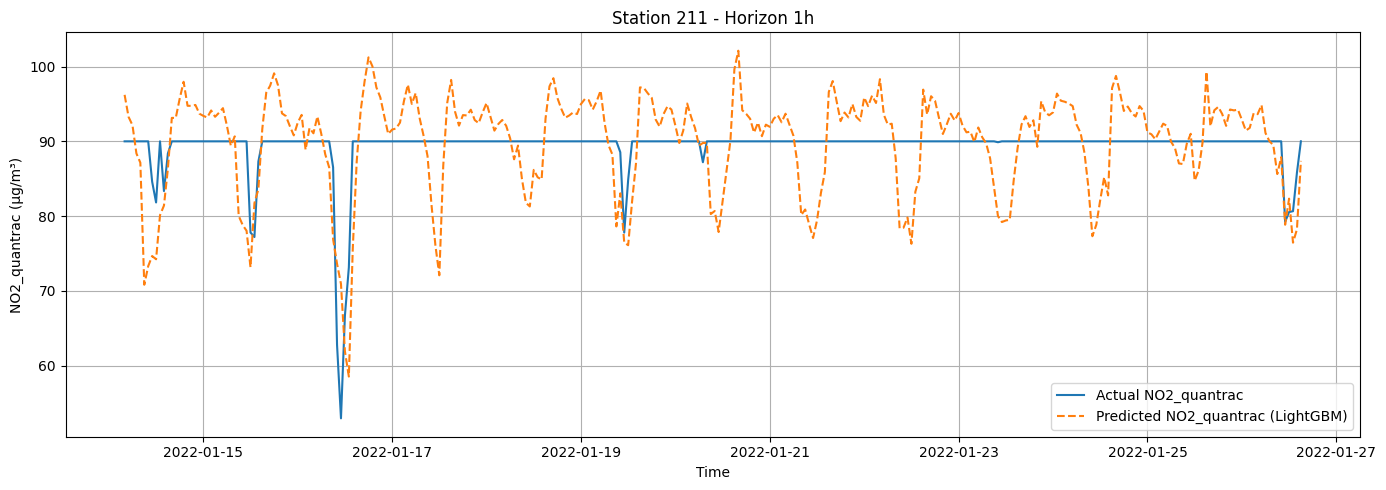

hour = 24
IQR value for column NO2_quantrac_t_plus_24h is: 60.76538594856204
lower_range = -25.704569148134695, upper_range = 217.35697464611349


NO2_quantrac_t_plus_24h
3309                 90.000000
3310                 90.000000
3311                 90.000000
3312                 90.000000
3313                 88.701296
...                        ...
38416               166.161013
38417               156.713627
38418               158.753760
38419               125.515280
38420               127.649573

[5766 rows x 1 columns]

Removed indices: [37776, 37864, 38032]


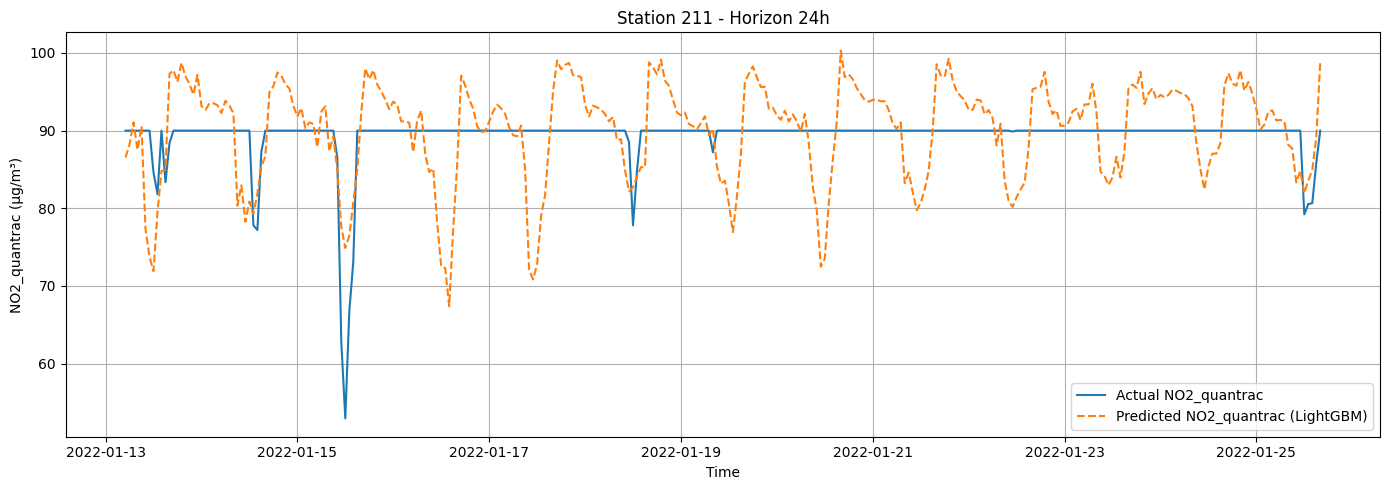

hour = 48
IQR value for column NO2_quantrac_t_plus_48h is: 61.019175642807596
lower_range = -26.08321244035234, upper_range = 217.99349013087806


NO2_quantrac_t_plus_48h
3289                 88.701296
3290                 90.000000
3291                 86.185698
3292                 78.223638
3293                 90.000000
...                        ...
38272               166.161013
38273               156.713627
38274               158.753760
38275               125.515280
38276               127.649573

[5744 rows x 1 columns]

Removed indices: [37632, 37888]


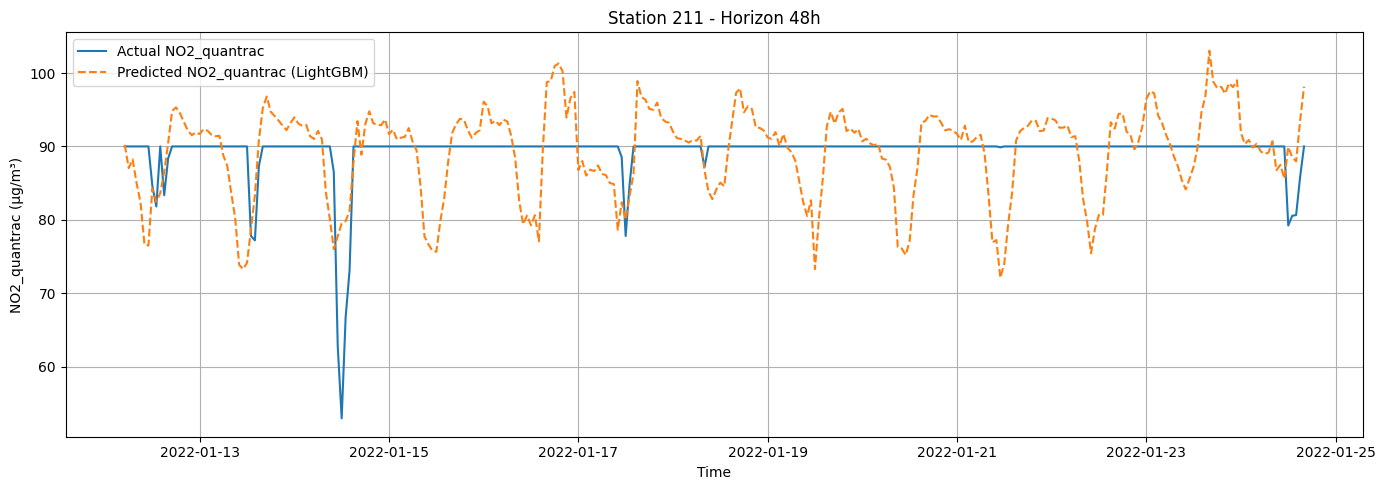

hour = 72
IQR value for column NO2_quantrac_t_plus_72h is: 60.90684135490747
lower_range = -25.92007672060204, upper_range = 217.70728869902786


NO2_quantrac_t_plus_72h
3269                 90.000000
3270                 90.000000
3271                 90.000000
3272                 90.000000
3273                 90.000000
...                        ...
38128               166.161013
38129               156.713627
38130               158.753760
38131               125.515280
38132               127.649573

[5723 rows x 1 columns]

Removed indices: [37488, 37744]


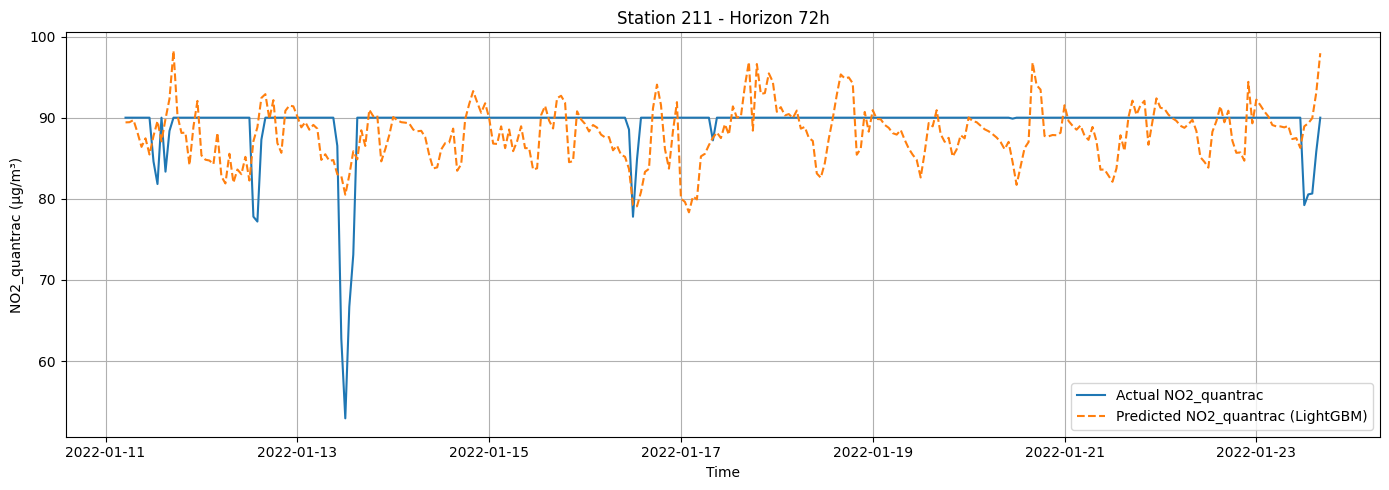

station_id = 212
hour = 1
IQR value for column NO2_quantrac_t_plus_1h is: 60.72952331666664
lower_range = -25.68962830833334, upper_range = 217.22846495833323


NO2_quantrac_t_plus_1h
3329                90.000000
3330                90.000000
3331                90.000000
3332                90.000000
3333                90.000000
...                       ...
38554              166.161013
38555              156.713627
38556              158.753760
38557              125.515280
38558              127.649573

[5787 rows x 1 columns]

Removed indices: [37914, 38002, 38170]


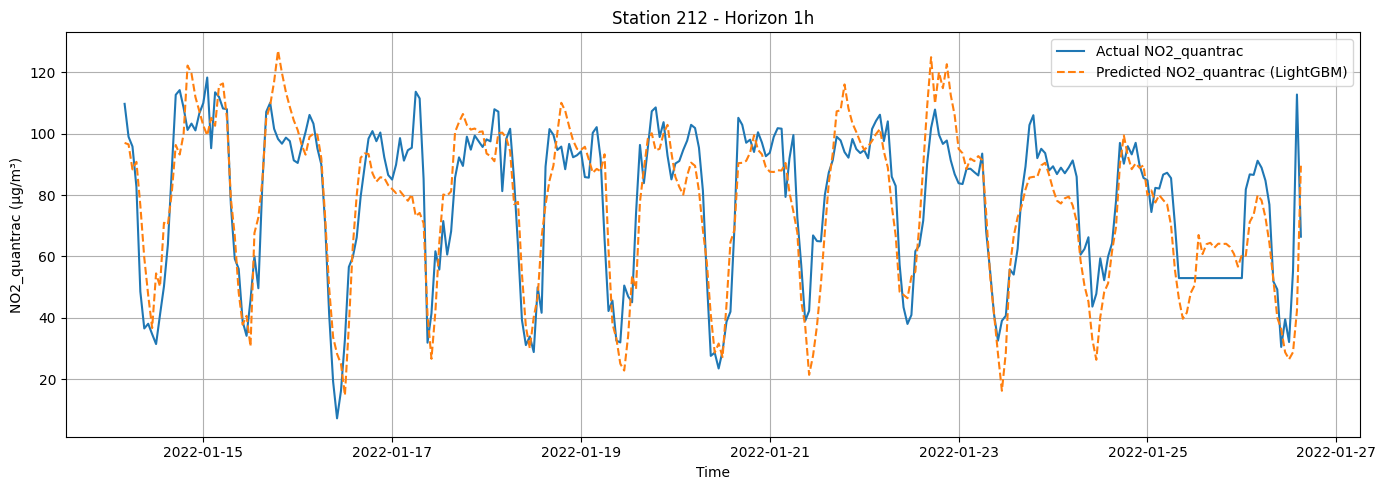

hour = 24
IQR value for column NO2_quantrac_t_plus_24h is: 60.76538594856204
lower_range = -25.704569148134695, upper_range = 217.35697464611349


NO2_quantrac_t_plus_24h
3309                 90.000000
3310                 90.000000
3311                 90.000000
3312                 90.000000
3313                 88.701296
...                        ...
38416               166.161013
38417               156.713627
38418               158.753760
38419               125.515280
38420               127.649573

[5766 rows x 1 columns]

Removed indices: [37776, 37864, 38032]


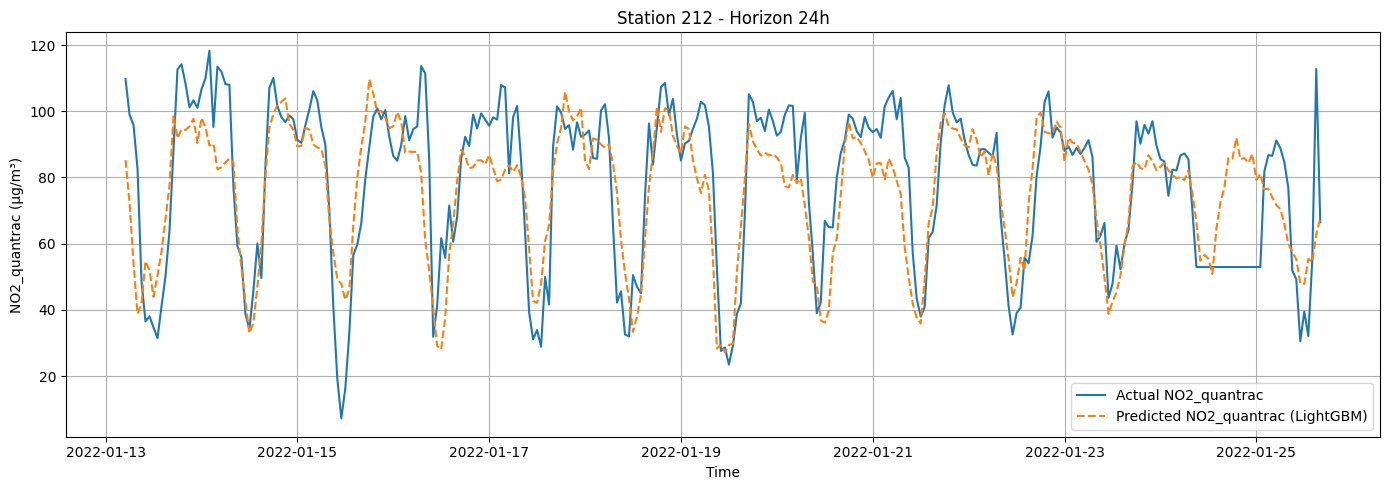

hour = 48
IQR value for column NO2_quantrac_t_plus_48h is: 61.019175642807596
lower_range = -26.08321244035234, upper_range = 217.99349013087806


NO2_quantrac_t_plus_48h
3289                 88.701296
3290                 90.000000
3291                 86.185698
3292                 78.223638
3293                 90.000000
...                        ...
38272               166.161013
38273               156.713627
38274               158.753760
38275               125.515280
38276               127.649573

[5744 rows x 1 columns]

Removed indices: [37632, 37888]


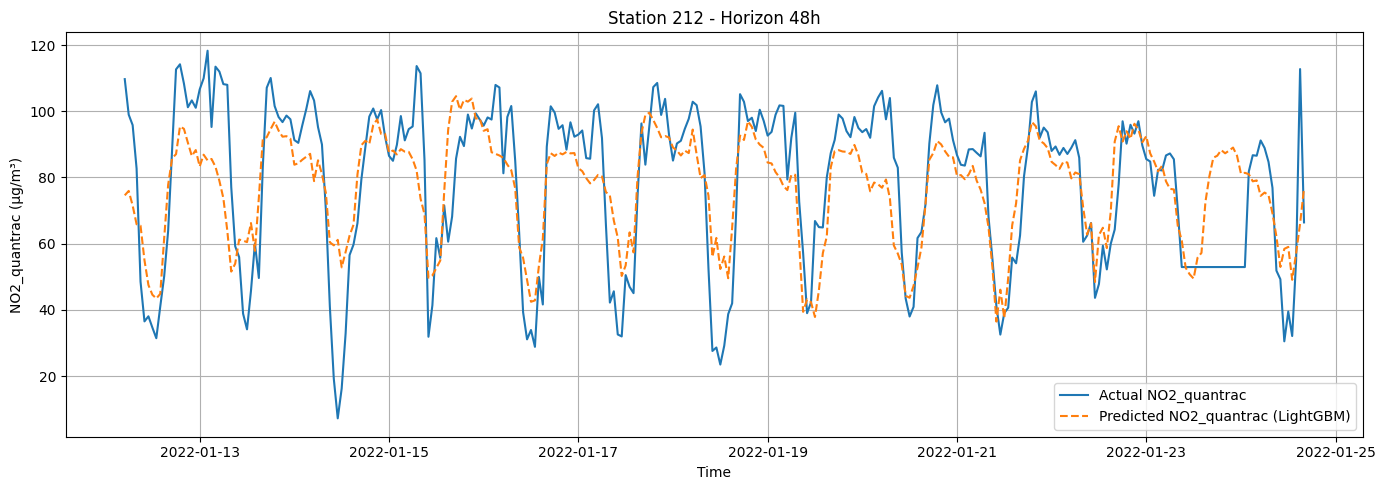

hour = 72
IQR value for column NO2_quantrac_t_plus_72h is: 60.90684135490747
lower_range = -25.92007672060204, upper_range = 217.70728869902786


NO2_quantrac_t_plus_72h
3269                 90.000000
3270                 90.000000
3271                 90.000000
3272                 90.000000
3273                 90.000000
...                        ...
38128               166.161013
38129               156.713627
38130               158.753760
38131               125.515280
38132               127.649573

[5723 rows x 1 columns]

Removed indices: [37488, 37744]


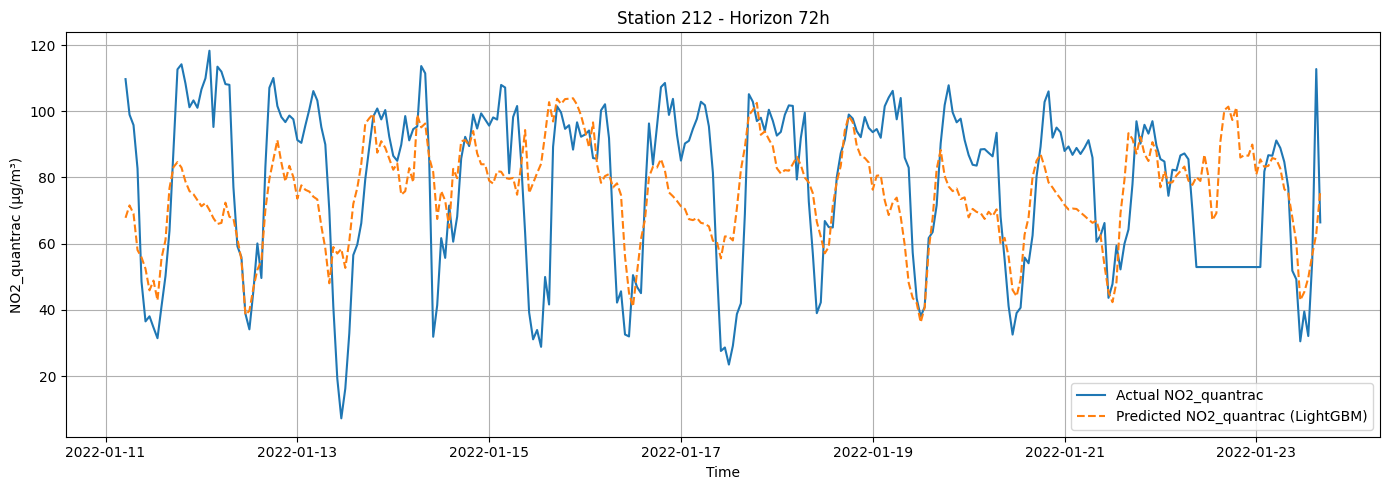

station_id = 213
hour = 1
IQR value for column NO2_quantrac_t_plus_1h is: 60.72952331666664
lower_range = -25.68962830833334, upper_range = 217.22846495833323


NO2_quantrac_t_plus_1h
3329                90.000000
3330                90.000000
3331                90.000000
3332                90.000000
3333                90.000000
...                       ...
38554              166.161013
38555              156.713627
38556              158.753760
38557              125.515280
38558              127.649573

[5787 rows x 1 columns]

Removed indices: [37914, 38002, 38170]


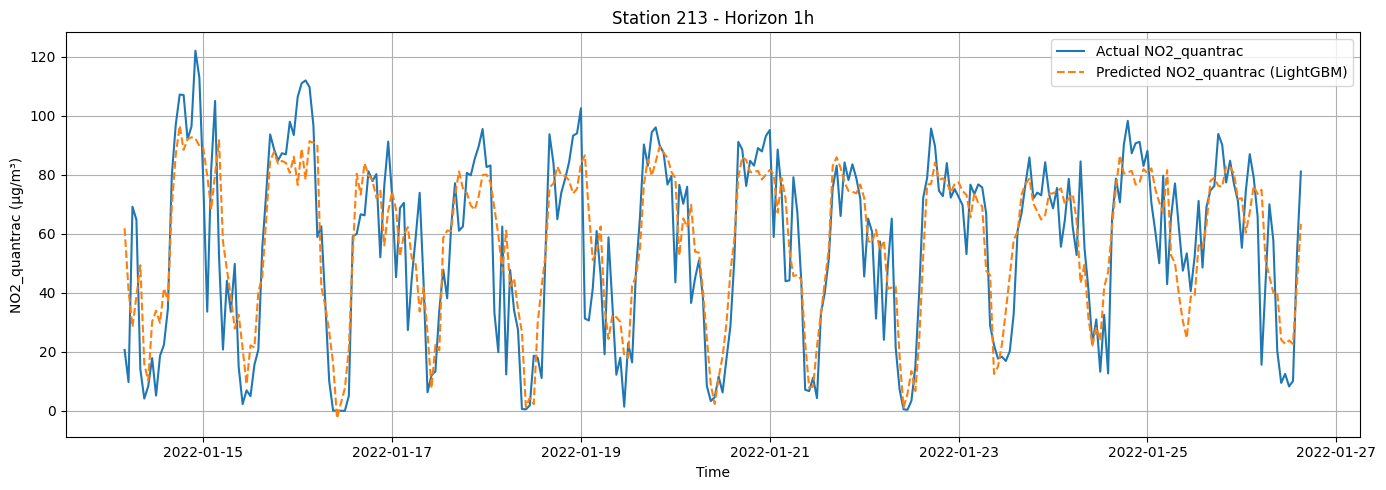

hour = 24
IQR value for column NO2_quantrac_t_plus_24h is: 60.76538594856204
lower_range = -25.704569148134695, upper_range = 217.35697464611349


NO2_quantrac_t_plus_24h
3309                 90.000000
3310                 90.000000
3311                 90.000000
3312                 90.000000
3313                 88.701296
...                        ...
38416               166.161013
38417               156.713627
38418               158.753760
38419               125.515280
38420               127.649573

[5766 rows x 1 columns]

Removed indices: [37776, 37864, 38032]


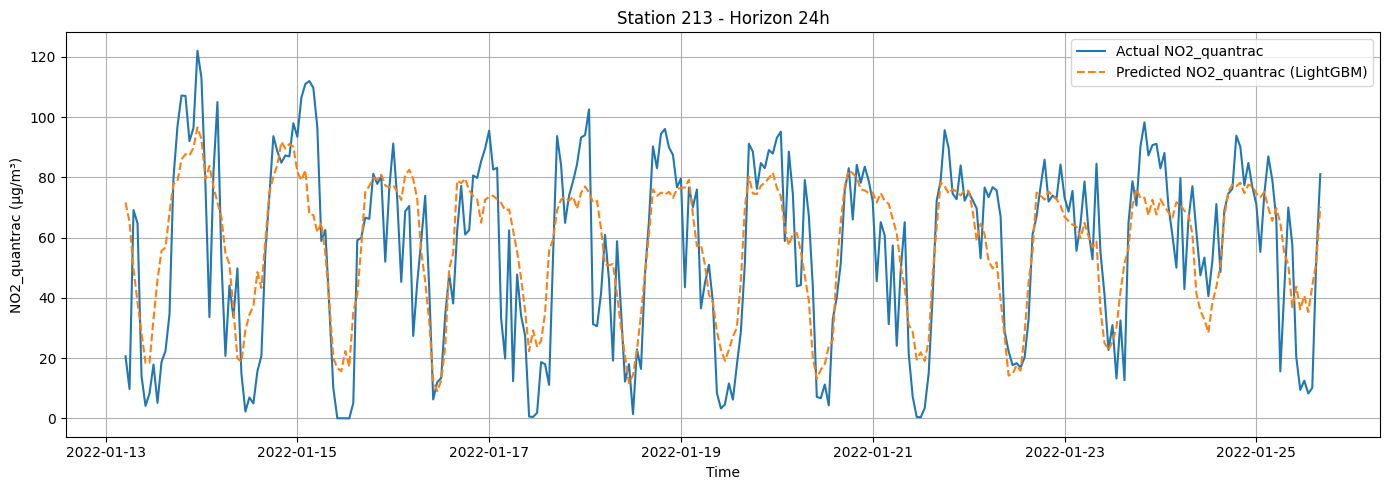

hour = 48
IQR value for column NO2_quantrac_t_plus_48h is: 61.019175642807596
lower_range = -26.08321244035234, upper_range = 217.99349013087806


NO2_quantrac_t_plus_48h
3289                 88.701296
3290                 90.000000
3291                 86.185698
3292                 78.223638
3293                 90.000000
...                        ...
38272               166.161013
38273               156.713627
38274               158.753760
38275               125.515280
38276               127.649573

[5744 rows x 1 columns]

Removed indices: [37632, 37888]


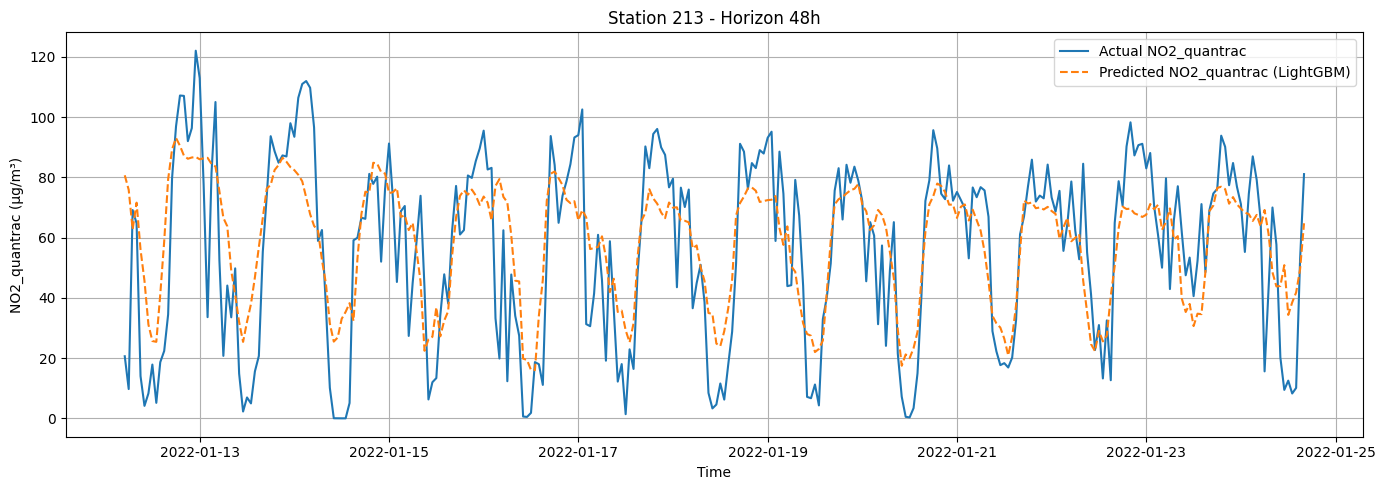

hour = 72
IQR value for column NO2_quantrac_t_plus_72h is: 60.90684135490747
lower_range = -25.92007672060204, upper_range = 217.70728869902786


NO2_quantrac_t_plus_72h
3269                 90.000000
3270                 90.000000
3271                 90.000000
3272                 90.000000
3273                 90.000000
...                        ...
38128               166.161013
38129               156.713627
38130               158.753760
38131               125.515280
38132               127.649573

[5723 rows x 1 columns]

Removed indices: [37488, 37744]


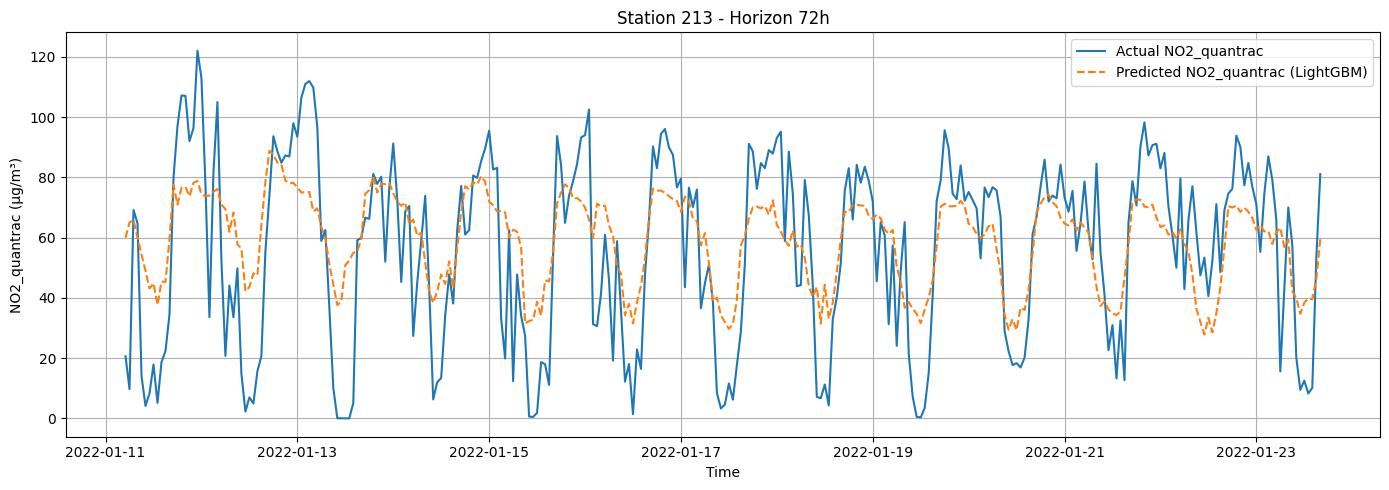

station_id = 214
hour = 1
IQR value for column NO2_quantrac_t_plus_1h is: 60.72952331666664
lower_range = -25.68962830833334, upper_range = 217.22846495833323


NO2_quantrac_t_plus_1h
3329                90.000000
3330                90.000000
3331                90.000000
3332                90.000000
3333                90.000000
...                       ...
38554              166.161013
38555              156.713627
38556              158.753760
38557              125.515280
38558              127.649573

[5787 rows x 1 columns]

Removed indices: [37914, 38002, 38170]


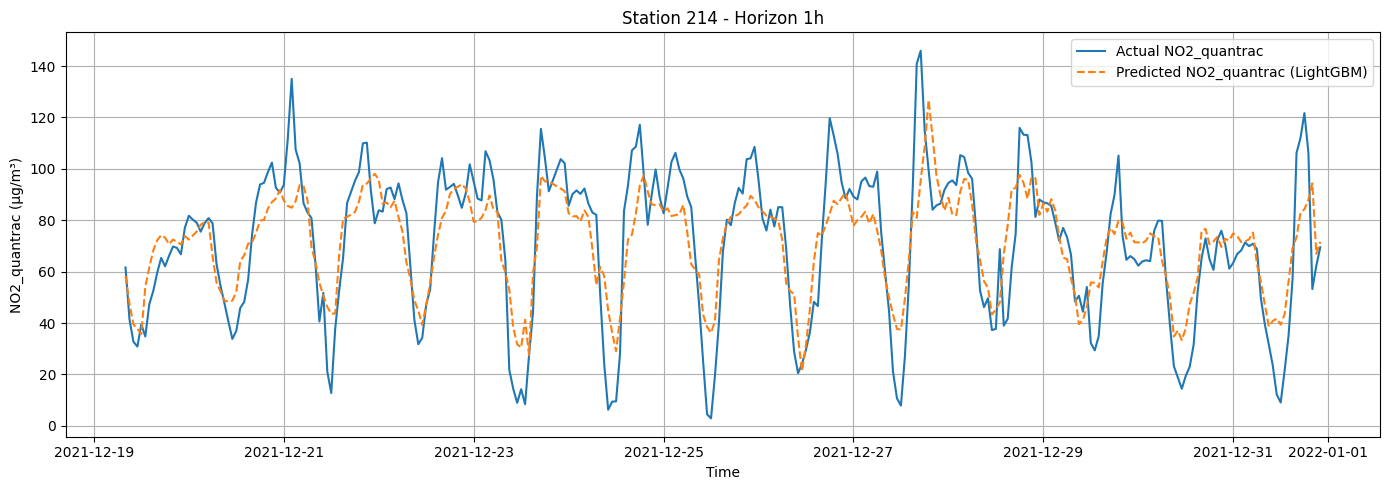

hour = 24
IQR value for column NO2_quantrac_t_plus_24h is: 60.76538594856204
lower_range = -25.704569148134695, upper_range = 217.35697464611349


NO2_quantrac_t_plus_24h
3309                 90.000000
3310                 90.000000
3311                 90.000000
3312                 90.000000
3313                 88.701296
...                        ...
38416               166.161013
38417               156.713627
38418               158.753760
38419               125.515280
38420               127.649573

[5766 rows x 1 columns]

Removed indices: [37776, 37864, 38032]


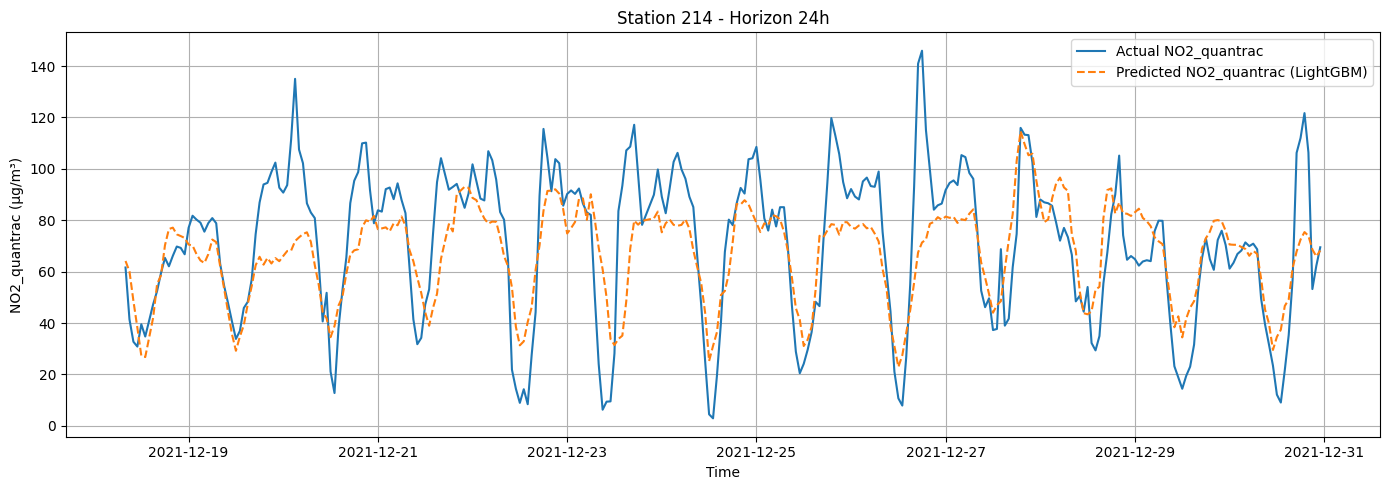

hour = 48
IQR value for column NO2_quantrac_t_plus_48h is: 61.019175642807596
lower_range = -26.08321244035234, upper_range = 217.99349013087806


NO2_quantrac_t_plus_48h
3289                 88.701296
3290                 90.000000
3291                 86.185698
3292                 78.223638
3293                 90.000000
...                        ...
38272               166.161013
38273               156.713627
38274               158.753760
38275               125.515280
38276               127.649573

[5744 rows x 1 columns]

Removed indices: [37632, 37888]


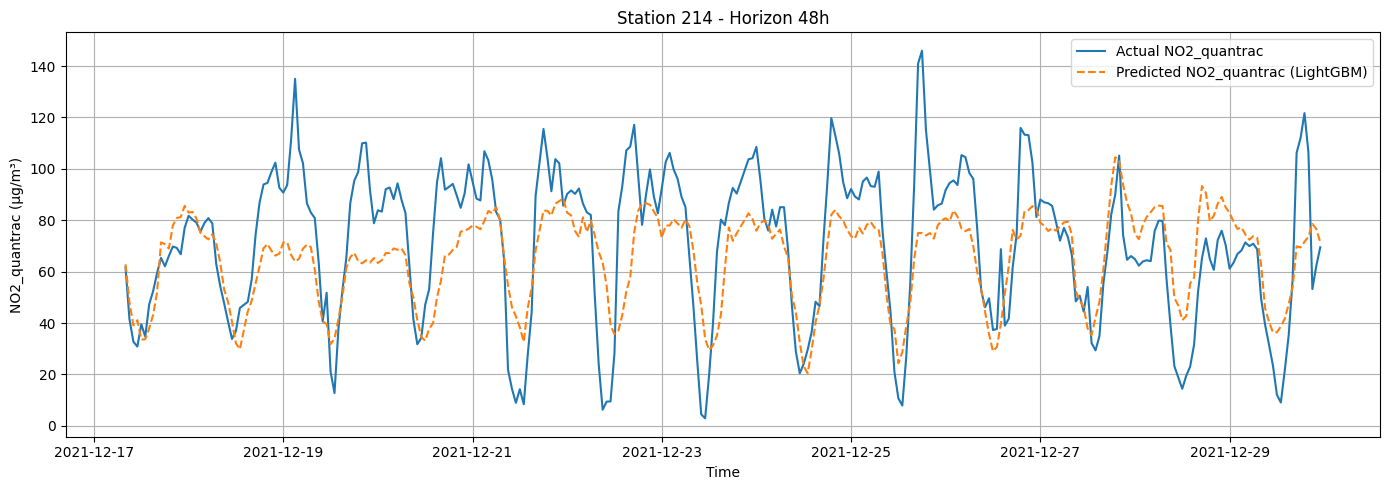

hour = 72
IQR value for column NO2_quantrac_t_plus_72h is: 60.90684135490747
lower_range = -25.92007672060204, upper_range = 217.70728869902786


NO2_quantrac_t_plus_72h
3269                 90.000000
3270                 90.000000
3271                 90.000000
3272                 90.000000
3273                 90.000000
...                        ...
38128               166.161013
38129               156.713627
38130               158.753760
38131               125.515280
38132               127.649573

[5723 rows x 1 columns]

Removed indices: [37488, 37744]


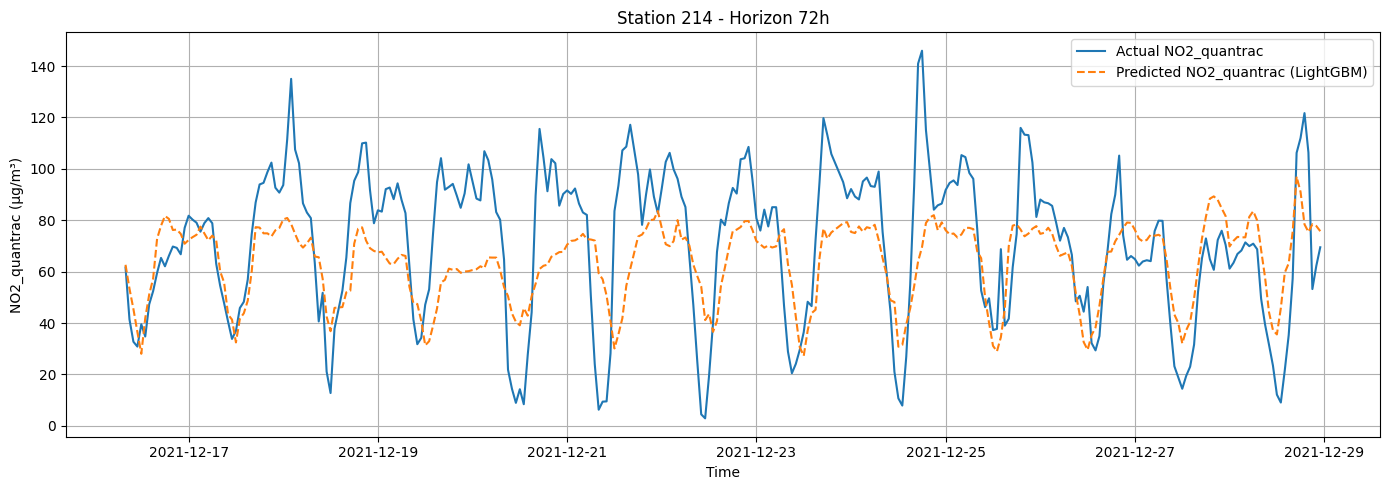

station_id = 215
hour = 1
IQR value for column NO2_quantrac_t_plus_1h is: 60.72952331666664
lower_range = -25.68962830833334, upper_range = 217.22846495833323


NO2_quantrac_t_plus_1h
3329                90.000000
3330                90.000000
3331                90.000000
3332                90.000000
3333                90.000000
...                       ...
38554              166.161013
38555              156.713627
38556              158.753760
38557              125.515280
38558              127.649573

[5787 rows x 1 columns]

Removed indices: [37914, 38002, 38170]


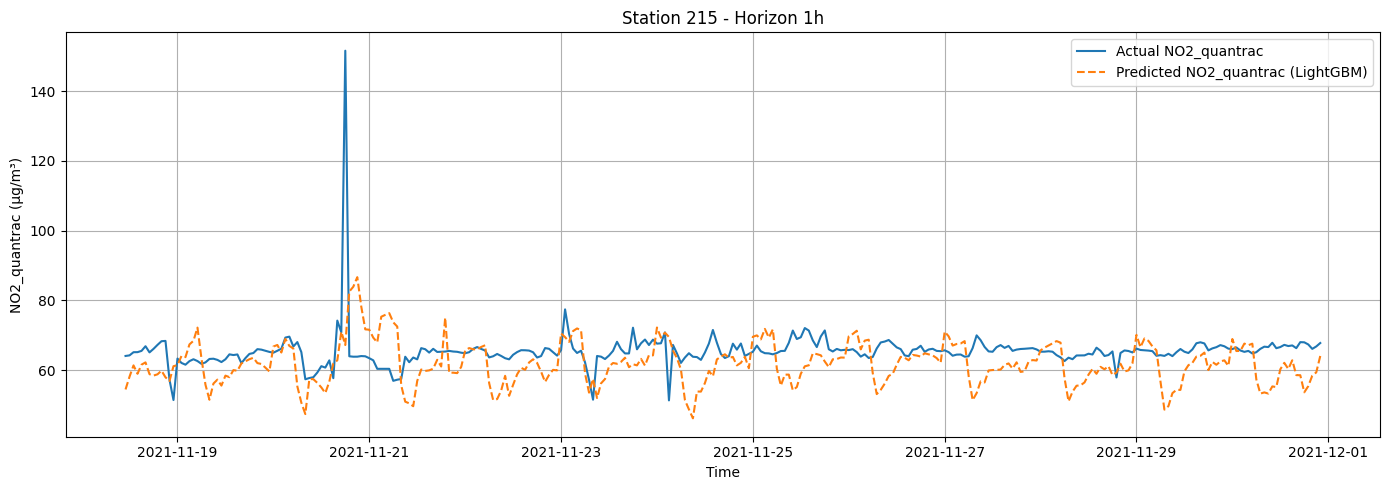

hour = 24
IQR value for column NO2_quantrac_t_plus_24h is: 60.76538594856204
lower_range = -25.704569148134695, upper_range = 217.35697464611349


NO2_quantrac_t_plus_24h
3309                 90.000000
3310                 90.000000
3311                 90.000000
3312                 90.000000
3313                 88.701296
...                        ...
38416               166.161013
38417               156.713627
38418               158.753760
38419               125.515280
38420               127.649573

[5766 rows x 1 columns]

Removed indices: [37776, 37864, 38032]


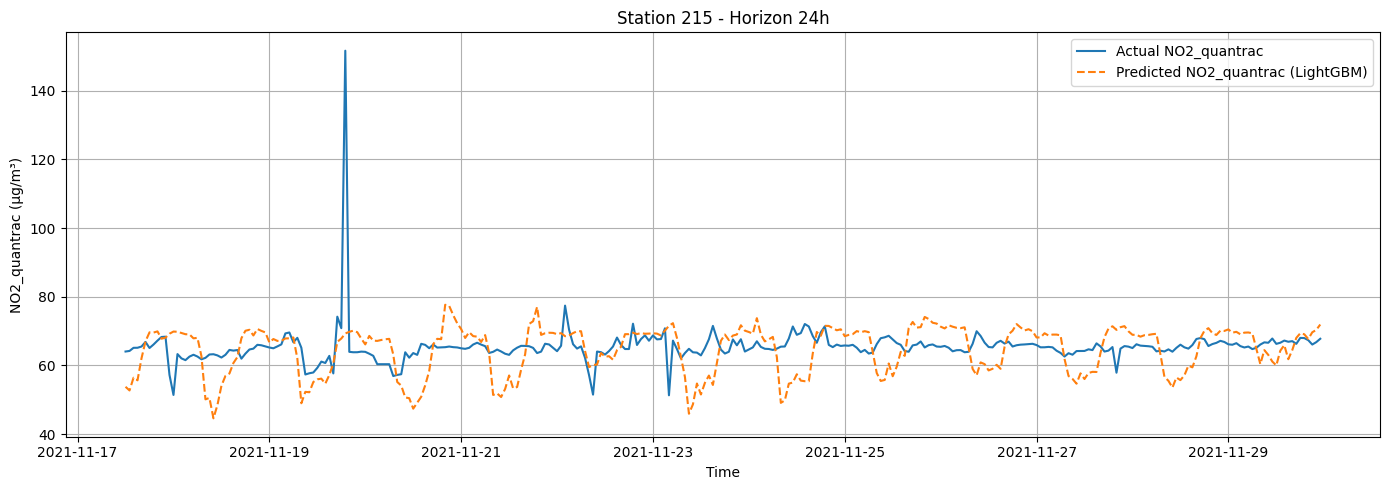

hour = 48
IQR value for column NO2_quantrac_t_plus_48h is: 61.019175642807596
lower_range = -26.08321244035234, upper_range = 217.99349013087806


NO2_quantrac_t_plus_48h
3289                 88.701296
3290                 90.000000
3291                 86.185698
3292                 78.223638
3293                 90.000000
...                        ...
38272               166.161013
38273               156.713627
38274               158.753760
38275               125.515280
38276               127.649573

[5744 rows x 1 columns]

Removed indices: [37632, 37888]


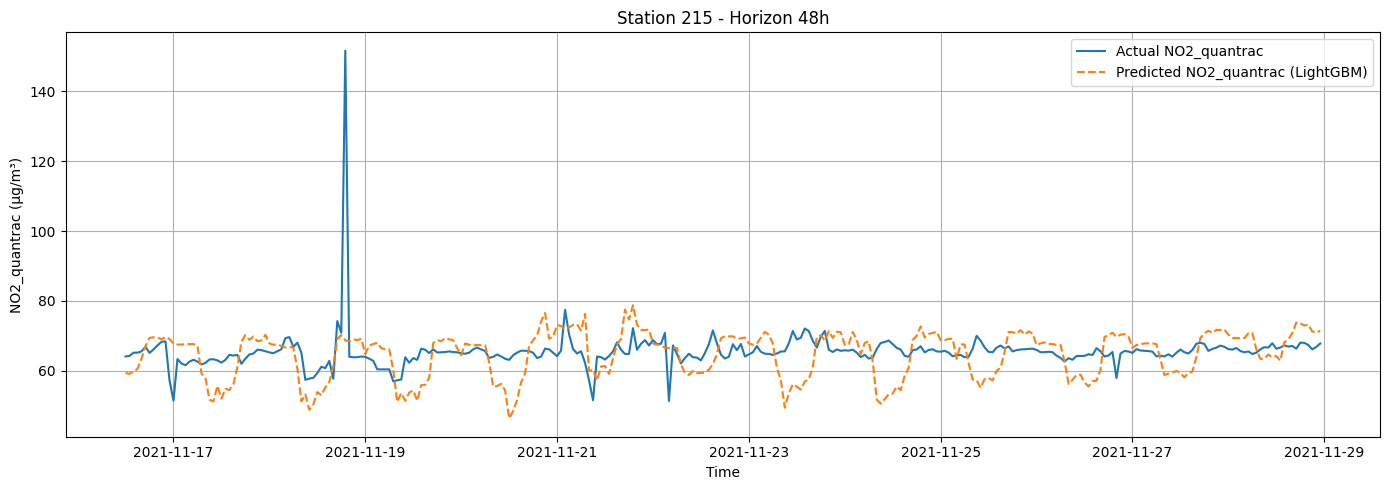

hour = 72
IQR value for column NO2_quantrac_t_plus_72h is: 60.90684135490747
lower_range = -25.92007672060204, upper_range = 217.70728869902786


NO2_quantrac_t_plus_72h
3269                 90.000000
3270                 90.000000
3271                 90.000000
3272                 90.000000
3273                 90.000000
...                        ...
38128               166.161013
38129               156.713627
38130               158.753760
38131               125.515280
38132               127.649573

[5723 rows x 1 columns]

Removed indices: [37488, 37744]


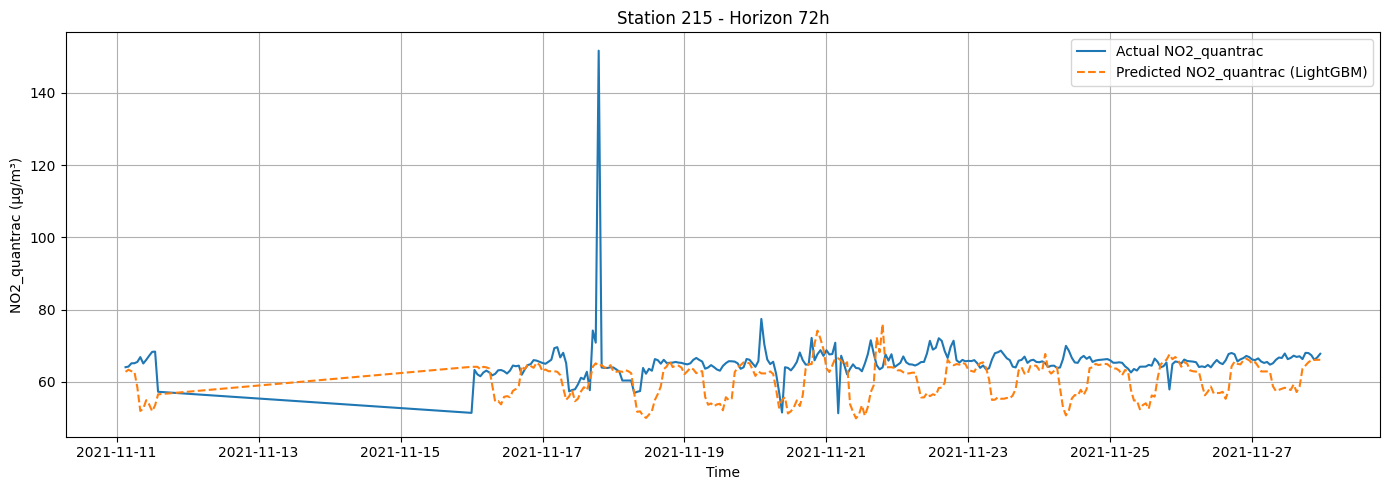

station_id = 216
hour = 1
IQR value for column NO2_quantrac_t_plus_1h is: 60.72952331666664
lower_range = -25.68962830833334, upper_range = 217.22846495833323


NO2_quantrac_t_plus_1h
3329                90.000000
3330                90.000000
3331                90.000000
3332                90.000000
3333                90.000000
...                       ...
38554              166.161013
38555              156.713627
38556              158.753760
38557              125.515280
38558              127.649573

[5787 rows x 1 columns]

Removed indices: [37914, 38002, 38170]


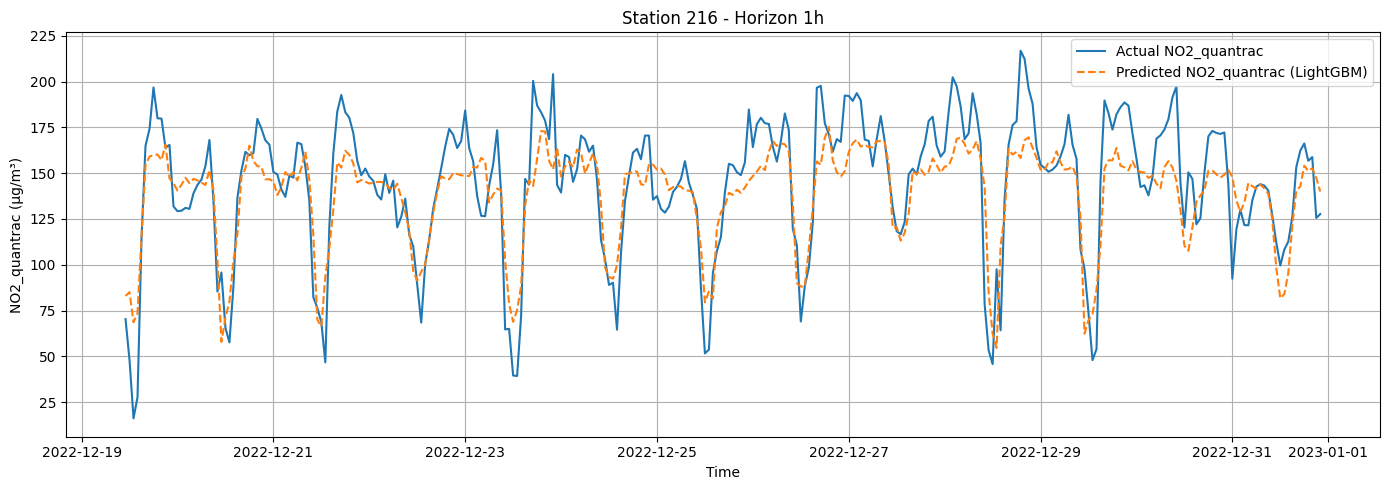

hour = 24
IQR value for column NO2_quantrac_t_plus_24h is: 60.76538594856204
lower_range = -25.704569148134695, upper_range = 217.35697464611349


NO2_quantrac_t_plus_24h
3309                 90.000000
3310                 90.000000
3311                 90.000000
3312                 90.000000
3313                 88.701296
...                        ...
38416               166.161013
38417               156.713627
38418               158.753760
38419               125.515280
38420               127.649573

[5766 rows x 1 columns]

Removed indices: [37776, 37864, 38032]


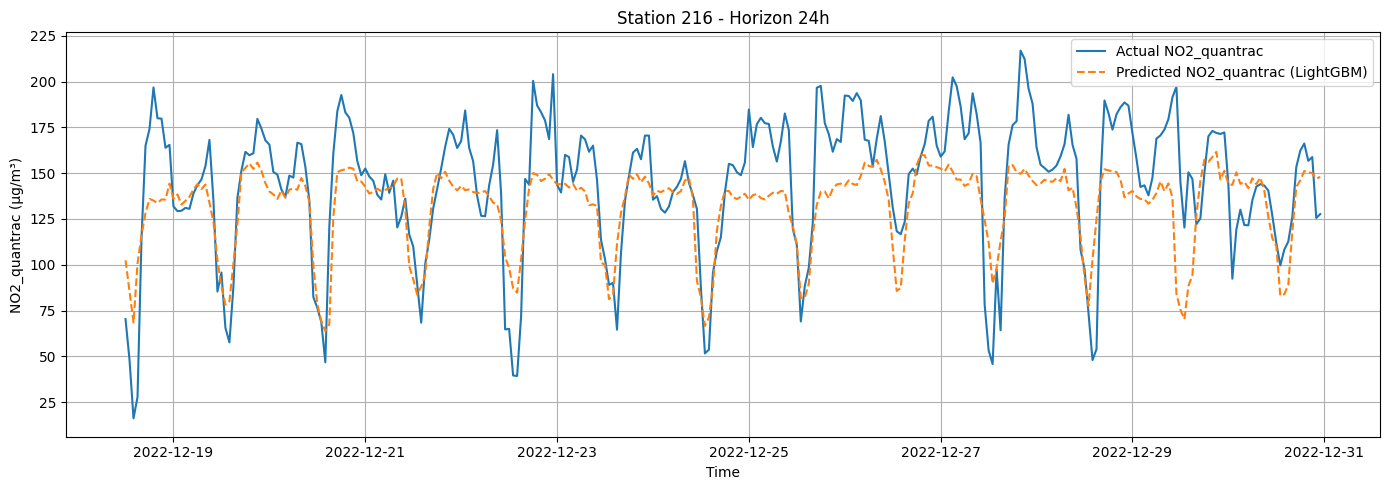

hour = 48
IQR value for column NO2_quantrac_t_plus_48h is: 61.019175642807596
lower_range = -26.08321244035234, upper_range = 217.99349013087806


NO2_quantrac_t_plus_48h
3289                 88.701296
3290                 90.000000
3291                 86.185698
3292                 78.223638
3293                 90.000000
...                        ...
38272               166.161013
38273               156.713627
38274               158.753760
38275               125.515280
38276               127.649573

[5744 rows x 1 columns]

Removed indices: [37632, 37888]


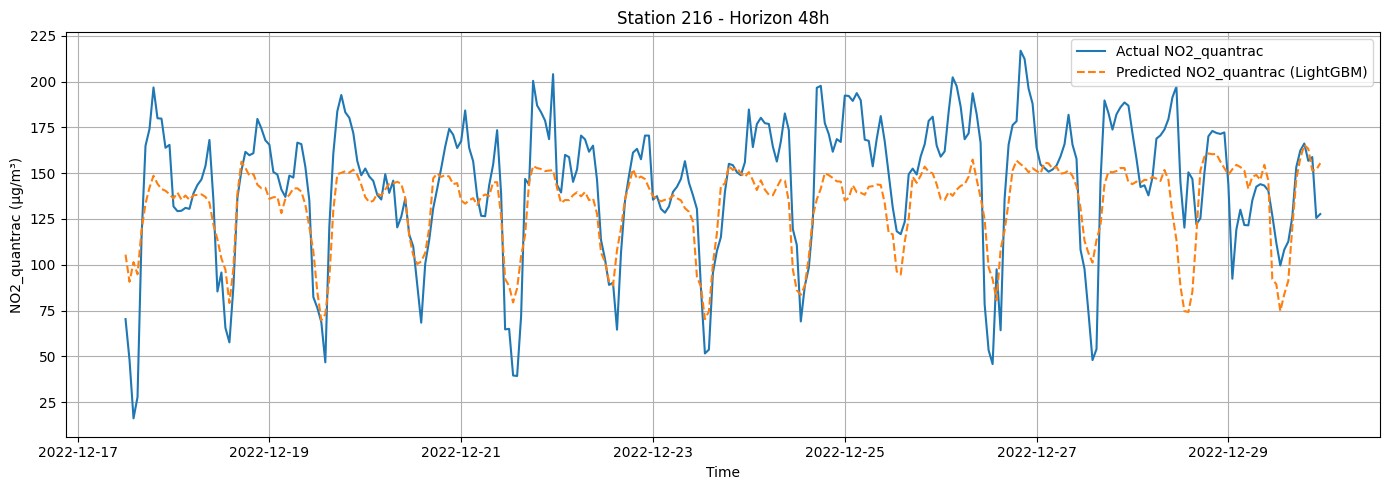

hour = 72
IQR value for column NO2_quantrac_t_plus_72h is: 60.90684135490747
lower_range = -25.92007672060204, upper_range = 217.70728869902786


NO2_quantrac_t_plus_72h
3269                 90.000000
3270                 90.000000
3271                 90.000000
3272                 90.000000
3273                 90.000000
...                        ...
38128               166.161013
38129               156.713627
38130               158.753760
38131               125.515280
38132               127.649573

[5723 rows x 1 columns]

Removed indices: [37488, 37744]


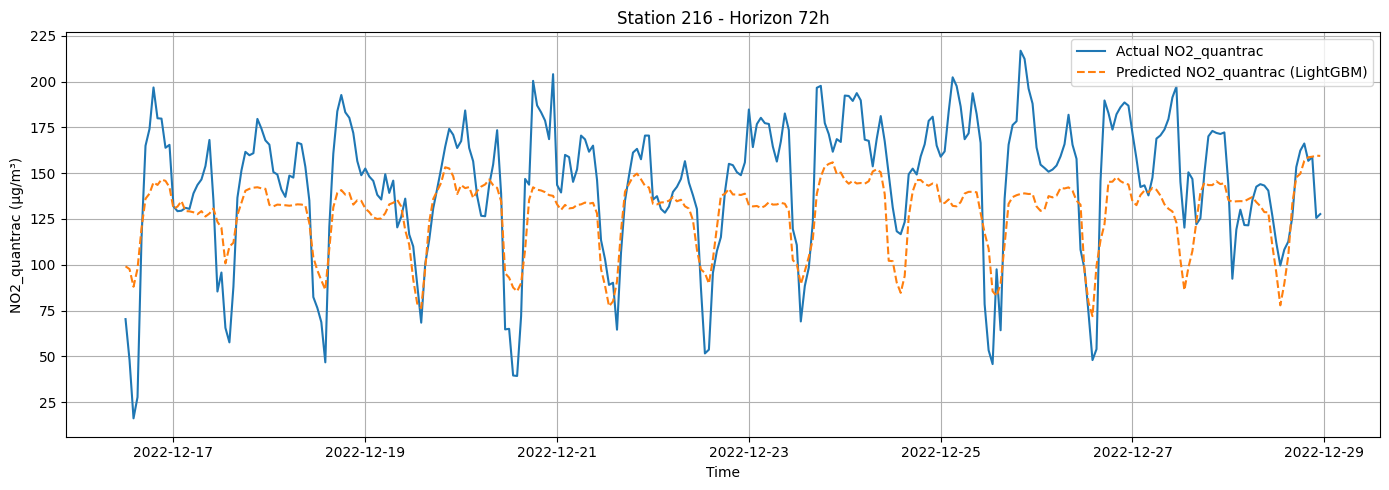

In [18]:
# Reference
for station_id in STATION_IDS:
    print(f"station_id = {station_id}")
    for hour in HORIZONS:
        print(f"hour = {hour}")
        plot_timeseries_example(df_no2, no2_models_by_h[hour], horizon_h=hour, station_id=station_id, target_col=label)

In [19]:
stop

NameError: name 'stop' is not defined

## Training for O3

In [ ]:
label = "O3_quantrac"

# Add rolling features for LABEL
df_o3 = add_rolling_features(df_converted, group_col="station_id", target_cols=[label], windows=ROLL_WINDOWS)
print(df_o3.columns)

# Start running model
o3_all_metrics = []
o3_models_by_h = {}
for h in HORIZONS:
    print(f"\n===== Training LightGBM for horizon = {h}h, target_col = {label} =====")
    model_h, metrics_overall, metrics_by_station, _ = train_lgbm_for_horizon(df_o3, horizon_h=h, target_col=label)
    o3_models_by_h[h] = model_h
    model_h.save_model(os.path.join(LIGHTGBM_DIR, f"{label}_lightgbm_{h}h"))
    print("Overall test metrics:", metrics_overall)
    o3_all_metrics.append(metrics_by_station)

o3_df_metrics_all = pd.concat(o3_all_metrics, ignore_index=True)
o3_df_metrics_all = o3_df_metrics_all.sort_values(["station", "horizon_h"])
o3_df_metrics_all.to_csv(os.path.join(LIGHTGBM_DIR, f"{label}_metrics.csv"))
o3_df_metrics_all

In [ ]:
# Reference
for station_id in STATION_IDS:
    print(f"station_id = {station_id}")
    for hour in [1, 24, 48, 72]:
        print(f"hour = {hour}")
        plot_timeseries_example(df_o3, o3_models_by_h[hour], horizon_h=hour, station_id=int(station_id), target_col=label)

## Training for CO

In [ ]:
label = "CO_quantrac"

# Add rolling features for LABEL
df_co = add_rolling_features(df_converted, group_col="station_id", target_cols=[label], windows=ROLL_WINDOWS)
print(df_co.columns)

# Start running model
co_all_metrics = []
co_models_by_h = {}
for h in HORIZONS:
    print(f"\n===== Training LightGBM for horizon = {h}h, target_col = {label} =====")
    model_h, metrics_overall, metrics_by_station, _ = train_lgbm_for_horizon(df_co, horizon_h=h, target_col=label)
    co_models_by_h[h] = model_h
    model_h.save_model(os.path.join(LIGHTGBM_DIR, f"{label}_lightgbm_{h}h"))
    print("Overall test metrics:", metrics_overall)
    co_all_metrics.append(metrics_by_station)

co_df_metrics_all = pd.concat(co_all_metrics, ignore_index=True)
co_df_metrics_all = co_df_metrics_all.sort_values(["station", "horizon_h"])
co_df_metrics_all.to_csv(os.path.join(LIGHTGBM_DIR, f"{label}_metrics.csv"))
co_df_metrics_all

In [ ]:
# Reference
for station_id in STATION_IDS:
    print(f"station_id = {station_id}")
    for hour in [1, 24, 48, 72]:
        print(f"hour = {hour}")
        plot_timeseries_example(df_co, co_models_by_h[hour], horizon_h=hour, station_id=int(station_id), target_col=label)